## Мировые линии центров зарядов:

$$
x_1(t) = \frac{1}{2} a_1 t^2, \quad x_2(t) = d + \frac{1}{2} a_2 t^2
$$

Мировые трубки — это области вокруг этих линий, с фиксированной шириной (в сопутствующей системе).


In [33]:
# accelerations
var("a_1, a_2")
assume(a_1, "real")
assume(a_2, "real")

# half-length of the charges
var("l")
assume(l, "real")

# distance between centers of the charges
var("d")
assume(d, "real")

# time duration of the tube starting from time when velocity of charge is zero
var("t_1, t_2")
assume(t_1, "real")
assume(t_2, "real")

# time duration of the tube starting from time when velocity of charge is zero
var("t_1r, t_2l")
assume(t_1r, "real")
assume(t_2l, "real")

# time when velocity of charge is zero
var("t1_0, t2_0")
assume(t1_0, "real")
assume(t2_0, "real")

assume(x, "real")

# уравнения мировых трубок двух зарядов в нерелятивистском приближении
t1   = t1_0 + sqrt(2*x/a_1)
t1_l = t1_0 + sqrt(2*(x+l)/a_1)
t1_r = t1_0 + sqrt(2*(x-l)/a_1)

t2   = t2_0 + sqrt(2*(x-d)/a_2)
t2_l = t2_0 + sqrt(2*(x+l-d)/a_2)
t2_r = t2_0 + sqrt(2*(x-l-d)/a_2)

Как найти уравнение перпендикуляра

Найдите угловой коэффициент (наклон) мировой линии. Если угловой коэффициент мировой линии равен $k= (dt/dx) = \frac{1}{\left(a_1 \cdot t_1\right)}$,

In [34]:
show(t1.diff(x).expand())

1/2*sqrt(2)/(a_1*sqrt(x/a_1))

 то угловой коэффициент перпендикулярной прямой равен $ m = -1/k = (dt/dx) = -\left(a_1 \cdot t_1\right)$. 
Используйте формулу уравнения прямой вида $t_1 = -\left(a_1 \cdot t_1\right) x + b$, подставив точку проведения перпендикуляра отрезка и новый угловой коэффициент, чтобы найти b. 

 $t_1 = -\left(a_1 \cdot t_1\right) \frac{1}{2} a_1 t_1^2 + b$
 
 $b = t_1  + \frac{a_1^2}{2}  t_1^3$

In [35]:
def tubes_plot(A1, A2, L, D, T1, T2, T1_start = 0.0, T2_start = 0.0, mode='simple', logging=False):
    """
    mode: 
        'simple'  -> перпендикуляры к центральной линии
        'perp'    -> перпендикуляры от границ к центру
        'exponential'  -> Если условие перпендикулярности
                          $t'(x) = -A_1 t(x)$ выполняется
                          всюду внутри трубки, то кривая — **экспонента**
    """

    # displacement of charge 1 center
    # перемещение центра каждого из зарядов исходя из ускорения и времени
    S1 = A1*(T1-T1_start)^2/2
    S2 = A2*(T2-T2_start)^2/2

    values = [a_1 == A1, a_2 == A2, d == D, l == L, t1_0 == T1_start, t2_0 == T2_start]

    # Центральные точки
    x_1 = S1
    x_2 = D + S2
    t_1 = T1
    t_2 = T2

    # угловой коэффициент прямой перпендикулярной центральной мировой линии 
    # в точке, соответствующей вычисленной выше перемещению равен
    # $ m = -1/k = (dt/dx) = -\left(a_1 \cdot t_1\right)$.
    m1 = -A1*T1
    m2 = -A2*T2

    # Используйте формулу уравнения прямой вида
    # $t_1 = -\left(a_1 \cdot t_1\right) x + b$,
    # подставив точку проведения перпендикуляра отрезка
    # и новый угловой коэффициент, чтобы найти b.
    b1 = t_1 - m1 * x_1
    b2 = t_2 - m2 * x_2

    # уравнения прямой перпендикулярной центральной мировой линии каждого из зарядов
    perp_1 = m1*x + b1
    perp_2 = m2*x + b2

    # x координата точки пересечения перпендикуляра к центральной мировой линии
    # с левой и правой границей мировой трубки
    # для каждого из зарядов

    # === Исправленная функция поиска пересечения ===
    def solve_intersection(curve_expr, line_expr, var_x=x, domain_lower=0, make_square=True):
        curve_num = curve_expr.subs(values)
        line_num = line_expr.subs(values)
        
        if make_square:
            # Уравнение: curve_num == line_num → возводим в квадрат
            eq = (curve_num)^2 == (line_num)^2
            #eq = ((curve_num)^2).expand() == ((line_num)^2).expand()
        else:
            eq = curve_num == line_num
        #print("eq", eq)
            

        sol = solve(eq, var_x, solution_dict=True)
        #print("sol", sol)
        valid_solutions = []

        for s in sol:
            xv = s[var_x]
            xv_num = xv.subs(values)#.n()
            if not xv_num.is_real():
                continue
            xv_val = float(xv_num)
            if xv_val < domain_lower - 1e-6:
                continue

            # Проверка: не появился ли "лишний" корень?
            t_curve = curve_num.subs(var_x == xv_val).n()
            t_line  = line_num.subs(var_x == xv_val).n()
            if abs(t_curve - t_line) < 1e-6 and t_curve >= 0:
                valid_solutions.append(xv_val)

        if not valid_solutions:
            return None
        # Возвращаем ближайшее к центру решение
        center = (x_1 if '1' in str(curve_expr) else x_2)
        return min(valid_solutions, key=lambda xv: abs(xv - center))

    if mode == 'simple':
        # Найдём пересечения перпендикуляров к центру с границами
        x_1_l = solve_intersection(t1_l, perp_1, domain_lower=-L)
        x_1_r = solve_intersection(t1_r, perp_1, domain_lower=L)

        x_2_l = solve_intersection(t2_l, perp_2, domain_lower=D - L)
        x_2_r = solve_intersection(t2_r, perp_2, domain_lower=D + L)

        if logging:
            print("x_1_l", x_1_l)
            print("x_1_r", x_1_r)
            print("x_2_l", x_1_l)
            print("x_2_r", x_1_r)


        x_1_l = solve ((t1_l^2 == perp_1^2).subs(values), [x])[0].rhs()
        x_1_r = solve ((t1_r^2 == perp_1^2).subs(values), [x])[0].rhs()

        x_2_l = solve ((t2_l^2 == perp_2^2).subs(values), [x])[0].rhs()
        x_2_r = solve ((t2_r^2 == perp_2^2).subs(values), [x])[0].rhs()

        if logging:
            print("x_1_l", x_1_l)
            print("x_1_r", x_1_r)
            print("x_2_l", x_1_l)
            print("x_2_r", x_1_r)
        
        # t координата точки пересечения перпендикуляра к центральной мировой линии
        # с левой и правой границей мировой трубки
        # для каждого из зарядов

        # t координаты точек пересечения
        t_1_l = t1_l.subs(x == x_1_l).subs(values)
        t_1_r = t1_r.subs(x == x_1_r).subs(values)

        t_2_l = t2_l.subs(x == x_2_l).subs(values)
        t_2_r = t2_r.subs(x == x_2_r).subs(values)

        # угловой коэффициент прямой перпендикулярной левой и правой границе мировой трубки
        # $ m = -1/k = (dt/dx) = -\left(a_1 \cdot t_1\right)$.
        m1_l = -A1*t_1_l
        m1_r = -A1*t_1_r
        m2_l = -A2*t_2_l
        m2_r = -A2*t_2_r

        # Используйте формулу уравнения прямой вида
        # $t_1 = -\left(a_1 \cdot t_1\right) x + b$,
        # подставив точку проведения перпендикуляра отрезка
        # и новый угловой коэффициент, чтобы найти b.
        b1_l = t_1_l - m1_l * x_1_l
        b1_r = t_1_r - m1_r * x_1_r

        b2_l = t_2_l - m2_l * x_2_l
        b2_r = t_2_r - m2_r * x_2_r

        # уравнения прямой перпендикулярной левой и правой границе мировой трубки каждого из зарядов
        perp_1_l = m1_l*x + b1_l
        perp_1_r = m1_r*x + b1_r
        perp_2_l = m2_l*x + b2_l
        perp_2_r = m2_r*x + b2_r

        # x координата точки пересечения перпендикуляра к левой и правой границе мировой трубки
        # с противоположной границей мировой трубки
        # для каждого из зарядов

        x_1_lr = solve ((t1_l^2 == perp_1_r^2).subs(values), [x])[1].rhs()
        x_1_rl = solve ((t1_r^2 == perp_1_l^2).subs(values), [x])[1].rhs()

        x_2_lr = solve ((t2_l^2 == perp_2_r^2).subs(values), [x])[1].rhs()
        x_2_rl = solve ((t2_r^2 == perp_2_l^2).subs(values), [x])[1].rhs()
    elif mode == 'perp':
        # t координата точки пересечения перпендикуляра к левой и правой границе мировой трубки
        # с точкой на центральной мировой линии
        # для каждого из зарядов
        t_1_lc = var("t_1_lc")
        t_1_rc = var("t_1_rc")

        t_2_lc = var("t_2_lc")
        t_2_rc = var("t_2_rc")

        # x координата точки пересечения перпендикуляра к левой и правой границе мировой трубки
        # с точкой на центральной мировой линии
        # для каждого из зарядов
        x_1_lc = var("x_1_lc")
        x_1_rc = var("x_1_rc")

        x_2_lc = var("x_2_lc")
        x_2_rc = var("x_2_rc")

        # угловой коэффициент прямой перпендикулярной левой и правой границе мировой трубки
        # $ m = -1/k = (dt/dx) = -\left(a_1 \cdot t_1\right)$.
        # в только что выше обозначенных точках t_1_l_, t_1_r_, t_2_l_, t_2_r_
        m1_lc = -A1*t_1_lc
        m1_rc = -A1*t_1_rc
        m2_lc = -A2*t_2_lc
        m2_rc = -A2*t_2_rc

        if logging:
            print("m1_lc = ", m1_lc)
            print("m1_rc = ", m1_rc)
            print("m2_lc = ", m2_lc)
            print("m2_rc = ", m2_rc)

        # Используйте формулу уравнения прямой вида
        # $t_1 = -\left(a_1 \cdot t_1\right) x + b$,
        # подставив точку пересечения перпендикуляра к центральной мировой линии с самой центральной мировой линией
        # и новый угловой коэффициент, чтобы найти b.

        b1_lc = var("b1_lc")
        b1_rc = var("b1_rc")

        b2_lc = var("b2_lc")
        b2_rc = var("b2_rc")

        # eqc_b1_lc = b1_lc == t_1 - m1_lc * x_1
        # eqc_b1_rc = b1_rc == t_1 - m1_rc * x_1

        # eqc_b2_lc = b2_lc == t_2 - m2_lc * x_2
        # eqc_b2_rc = b2_rc == t_2 - m2_rc * x_2

        eqc_b1_lc = t_1 == b1_lc + m1_lc * x_1 
        eqc_b1_rc = t_1 == b1_rc + m1_rc * x_1

        eqc_b2_lc = t_2 == b2_lc + m2_lc * x_2
        eqc_b2_rc = t_2 == b2_rc + m2_rc * x_2 

        if logging:
            print("eqc_b1_lc = ", eqc_b1_lc)
            print("eqc_b1_rc = ", eqc_b1_rc)
            print("eqc_b2_lc = ", eqc_b2_lc)
            print("eqc_b2_rc = ", eqc_b2_rc)

        # Используйте формулу уравнения прямой вида
        # $t_1 = -\left(a_1 \cdot t_1\right) x + b$,
        # подставив точку проведения перпендикуляра отрезка
        # и новый угловой коэффициент, чтобы найти b.
        eq_b1_lc = b1_lc == t_1_lc - m1_lc * x_1_lc
        eq_b1_rc = b1_rc == t_1_rc - m1_rc * x_1_rc

        eq_b2_lc = b2_lc == t_2_lc - m2_lc * x_2_lc
        eq_b2_rc = b2_rc == t_2_rc - m2_rc * x_2_rc

        if logging:
            print("eq_b1_lc = ", eq_b1_lc)
            print("eq_b1_rc = ", eq_b1_rc)
            print("eq_b2_lc = ", eq_b2_lc)
            print("eq_b2_rc = ", eq_b2_rc)

        # eq_c_b1_lc = t_1_lc - m1_lc * x_1_lc == t_1 - m1_lc * x_1
        # eq_c_b1_rc = t_1_rc - m1_rc * x_1_rc == t_1 - m1_rc * x_1

        # eq_c_b2_lc = t_2_lc - m2_lc * x_2_lc == t_2 - m2_lc * x_2
        # eq_c_b2_rc = t_2_rc - m2_rc * x_2_rc == t_2 - m2_rc * x_2

        eq_c_b1_lc = eqc_b1_lc.solve(b1_lc)[0].rhs() == eq_b1_lc.solve(b1_lc)[0].rhs()
        eq_c_b1_rc = eqc_b1_rc.solve(b1_rc)[0].rhs() == eq_b1_rc.solve(b1_rc)[0].rhs()

        eq_c_b2_lc = eqc_b2_lc.solve(b2_lc)[0].rhs() == eq_b2_lc.solve(b2_lc)[0].rhs()
        eq_c_b2_rc = eqc_b2_rc.solve(b2_rc)[0].rhs() == eq_b2_rc.solve(b2_rc)[0].rhs()

        if logging:
            print("eq_c_b1_lc = ", eq_c_b1_lc)
            print("eq_c_b1_rc = ", eq_c_b1_rc)
            print("eq_c_b2_lc = ", eq_c_b2_lc)
            print("eq_c_b2_rc = ", eq_c_b2_rc)

        # уравнения прямой перпендикулярной левой и правой границе мировой трубки каждого из зарядов
        perp_1_lc = m1_lc*x + b1_lc
        perp_1_rc = m1_rc*x + b1_rc
        perp_2_lc = m2_lc*x + b2_lc
        perp_2_rc = m2_rc*x + b2_rc

        if logging:
            print("perp_1_lc = ", perp_1_lc)
            print("perp_1_rc = ", perp_1_rc)
            print("perp_2_lc = ", perp_2_lc)
            print("perp_2_rc = ", perp_2_rc)

        # x координата точки пересечения перпендикуляра к левой и правой границе мировой трубки
        # с противоположной границей мировой трубки
        # для каждого из зарядов

        eq_x_1_lc = (t1_l^2 == t_1_lc^2).solve(x)[0].subs(x == x_1_lc).subs(values)
        eq_x_1_rc = (t1_r^2 == t_1_rc^2).solve(x)[0].subs(x == x_1_rc).subs(values)
        eq_x_2_lc = (t2_l^2 == t_2_lc^2).solve(x)[0].subs(x == x_2_lc).subs(values)
        eq_x_2_rc = (t2_r^2 == t_2_rc^2).solve(x)[0].subs(x == x_2_rc).subs(values)

        if logging:
            print("eq_x_1_lc = ", eq_x_1_lc)
            print("eq_x_1_rc = ", eq_x_1_rc)
            print("eq_x_2_lc = ", eq_x_2_lc)
            print("eq_x_2_rc = ", eq_x_2_rc)

        eq_t_1_lc = eq_c_b1_lc.subs(eq_x_1_lc)
        eq_t_1_rc = eq_c_b1_rc.subs(eq_x_1_rc)
        eq_t_2_lc = eq_c_b2_lc.subs(eq_x_2_lc)
        eq_t_2_rc = eq_c_b2_rc.subs(eq_x_2_rc)

        if logging:
            print("eq_t_1_lc = ", eq_t_1_lc)
            print("eq_t_1_rc = ", eq_t_1_rc)
            print("eq_t_2_lc = ", eq_t_2_lc)
            print("eq_t_2_rc = ", eq_t_2_rc)

        sol_t_1_lc = solve (eq_t_1_lc, t_1_lc)[2]
        sol_t_1_rc = solve (eq_t_1_rc, t_1_rc)[2]
        sol_t_2_lc = solve (eq_t_2_lc, t_2_lc)[2]
        sol_t_2_rc = solve (eq_t_2_rc, t_2_rc)[2]

        if logging:
            print("sol_t_1_lc = ", sol_t_1_lc)
            print("sol_t_1_rc = ", sol_t_1_rc)
            print("sol_t_2_lc = ", sol_t_2_lc)
            print("sol_t_2_rc = ", sol_t_2_rc)

        sol_x_1_lc = eq_x_1_lc.subs(sol_t_1_lc)
        sol_x_1_rc = eq_x_1_rc.subs(sol_t_1_rc)
        sol_x_2_lc = eq_x_2_lc.subs(sol_t_2_lc)
        sol_x_2_rc = eq_x_2_rc.subs(sol_t_2_rc)

        if logging:
            print("sol_x_1_lc = ", sol_x_1_lc)
            print("sol_x_1_rc = ", sol_x_1_rc)
            print("sol_x_2_lc = ", sol_x_2_lc)
            print("sol_x_2_rc = ", sol_x_2_rc)

        # t координата точки пересечения перпендикуляра к левой и правой границе мировой трубки
        # с точкой на центральной мировой линии
        # для каждого из зарядов
        t_1_l_c = t_1_lc.subs(sol_t_1_lc)
        t_1_r_c = t_1_rc.subs(sol_t_1_rc)

        t_2_l_c = t_2_lc.subs(sol_t_2_lc)
        t_2_r_c = t_2_rc.subs(sol_t_2_rc)

        # x координата точки пересечения перпендикуляра к левой и правой границе мировой трубки
        # с точкой на центральной мировой линии
        # для каждого из зарядов
        x_1_l_c = x_1_lc.subs(sol_x_1_lc)
        x_1_r_c = x_1_rc.subs(sol_x_1_rc)

        x_2_l_c = x_2_lc.subs(sol_x_2_lc)
        x_2_r_c = x_2_rc.subs(sol_x_2_rc)

        # уравнения прямой перпендикулярной левой и правой границе мировой трубки каждого из зарядов
        perp_1_l_c = perp_1_lc.subs(eqc_b1_lc.solve(b1_lc)).subs(sol_t_1_lc)
        perp_1_r_c = perp_1_rc.subs(eqc_b1_rc.solve(b1_rc)).subs(sol_t_1_rc)
        perp_2_l_c = perp_2_lc.subs(eqc_b2_lc.solve(b2_lc)).subs(sol_t_2_lc)
        perp_2_r_c = perp_2_rc.subs(eqc_b2_rc.solve(b2_rc)).subs(sol_t_2_rc)

        if logging:
            print("perp_1_l_c = ", perp_1_l_c)
            print("perp_1_r_c = ", perp_1_r_c)
            print("perp_2_l_c = ", perp_2_l_c)
            print("perp_2_r_c = ", perp_2_r_c)

    plt = Graphics()


    if mode == 'simple':
        plt_perp_1   = plot((perp_1, -perp_1),   x, x_1_l, x_1_r, color="red")
        plt_perp_2   = plot((perp_2, -perp_2),   x, x_2_l, x_2_r, color="red")

        plt += plt_perp_1
        plt += plt_perp_2
    #elif mode == 'simple':
        plt_perp_1_l   = plot((perp_1_l, -perp_1_l),   x, x_1_l, x_1_rl, color="green")
        plt_perp_1_r   = plot((perp_1_r, -perp_1_r),   x, x_1_lr, x_1_r, color="blue")
        plt_perp_2_l   = plot((perp_2_l, -perp_2_l),   x, x_2_l, x_2_rl, color="green")
        plt_perp_2_r   = plot((perp_2_r, -perp_2_r),   x, x_2_lr, x_2_r, color="blue")

        #plt += plt_perp_1_l
        #plt += plt_perp_1_r
        #plt += plt_perp_2_l
        #plt += plt_perp_2_r
    elif mode == 'perp':
        plt_perp_1_lc   = plot((perp_1_l_c, -perp_1_l_c),   x, x_1_l_c, x_1, color="green")
        plt_perp_1_rc   = plot((perp_1_r_c, -perp_1_r_c),   x, x_1, x_1_r_c, color="blue")
        plt_perp_2_lc   = plot((perp_2_l_c, -perp_2_l_c),   x, x_2_l_c, x_2, color="green")
        plt_perp_2_rc   = plot((perp_2_r_c, -perp_2_r_c),   x, x_2, x_2_r_c, color="blue")

        plt += plt_perp_1_lc
        plt += plt_perp_1_rc
        plt += plt_perp_2_lc
        plt += plt_perp_2_rc

    elif mode == 'exponential' or mode == 'exponential_between':
        # Для первого заряда
        x0_1 = S1
        t0_1 = T1_start + T1

        # Экспоненциальная кривая
        t_exp1(x) = t0_1 * exp(-A1 * (x - x0_1))

        # Левая граница: t_exp(x) = t1_l(x)
        def f_left1(x_val):
            try:
                # Проверяем, что подкоренное выражение неотрицательно
                if x_val + L < 0:
                    return float('nan')
                # Вычисляем значение
                val = t_exp1(x_val) - t1_l.subs(values).subs(x == x_val)
                val = t_exp1(x_val) - (T1_start + sqrt(2*(x_val + L)/A1))

                # Если val комплексное — возвращаем nan
                # ошибка ufunc 'isnan' not supported — это следствие того, что SageMath
                # (или его внутренний NumPy) не может обработать комплексные числа
                # или NaN при численном поиске корней.
                return float(val) if val.is_real() else float('nan')
            except:
                return float('nan')

        def f_right1(x_val):
            try:
                if x_val - L < 0:
                    return float('nan')
                val = t_exp1(x_val) - t1_r.subs(values).subs(x == x_val)
                # val = t_exp(x_val) - (T1_start + sqrt(2*(x_val - L)/A1))

                # Если val комплексное — возвращаем nan
                # ошибка ufunc 'isnan' not supported — это следствие того, что SageMath
                # (или его внутренний NumPy) не может обработать комплексные числа
                # или NaN при численном поиске корней.
                return float(val) if val.is_real() else float('nan')
            except:
                return float('nan')

        # Области поиска
        x_left_min1 = max(-L + 1e-6, x0_1 - 2*L)
        x_left_max1 = x0_1

        x_right_min1 = x0_1
        x_right_max1 = x0_1 + 2*L

        try:
            print("f_left1(x_left_min1)", f_left1(x_left_min1))
            print("f_left1(x_left_max1)", f_left1(x_left_max1))
            xL_exp1 = find_root(f_left1, x_left_min1, x_left_max1)
        except Exception as ex:
            print("Error in find_root for left boundary:", ex)
            xL_exp1 = x0_1 - L

        try:
            print("f_right1(x_right_min1)", f_right1(x_right_min1))
            print("f_right1(x_right_max1)", f_right1(x_right_max1))
            xR_exp1 = find_root(f_right1, x_right_min1, x_right_max1)
            tR_exp1 = T1_start + sqrt(2*(xR_exp1 - L)/A1)
        except Exception as ex:
            print("Error in find_root for right boundary:", ex)
            xR_exp1 = x0_1 + L
            tR_exp1 = T1_start + sqrt(2*(xR_exp1 - L)/A1)

        # Рисуем экспоненту между пересечениями
        plt += plot( t_exp1, x, xL_exp1, xR_exp1, color='orange', thickness=2)
        plt += plot(-t_exp1, x, xL_exp1, xR_exp1, color='orange', thickness=2)

        # Для второго заряда
        x0_2 = D + S2
        t0_2 = T2_start + T2
        t_exp2(x) = t0_2 * exp(-A2 * (x - x0_2))
        
        # Области определения границ
        x_left_domain2 = D - L  # левая граница определена при x <= x_left_domain2
        x_right_domain2 = D + L  # правая граница определена при x >= x_right_domain2
        
        def f_left2(x_val):
            try:
                if x_val + L - D < 0:
                    return float('nan')
                val = t_exp2(x_val) - (T2_start + sqrt(2*(x_val + L - D)/A2))

                # Если val комплексное — возвращаем nan
                # ошибка ufunc 'isnan' not supported — это следствие того, что SageMath
                # (или его внутренний NumPy) не может обработать комплексные числа
                # или NaN при численном поиске корней.
                return float(val) if val.is_real() else float('nan')
            except:
                return float('nan')

        def f_right2(x_val):
            if x_val < x_right_domain2:
                return float('nan')
            try:
                val = t_exp2(x_val) - (T2_start + sqrt(2*(x_val - L - D)/A2))

                # Если val комплексное — возвращаем nan
                # ошибка ufunc 'isnan' not supported — это следствие того, что SageMath
                # (или его внутренний NumPy) не может обработать комплексные числа
                # или NaN при численном поиске корней.
                return float(val) if val.is_real() else float('nan')            except:
                return float('nan')
            
        x_left_min2 = max(D - L + 1e-6, x0_2 - 2*L)
        x_left_max2 = x0_2
        x_right_min2 = x0_2-L
        x_right_max2 = x0_2 + 3*L
    
        # Интервалы поиска
        #x_left_min2 = max(D - L - 2*L, x0_2 - 2*L)  # достаточно далеко влево
        #x_left_max2 = min(x_left_domain2 - 1e-6, x0_2)

        x_right_min2 = max(x_right_domain2 + 1e-6, x0_2)
        #x_right_min2 = max(x0_2, D + L + 1e-6)  # = max(1.3725, 1.35 + 0.4) = 1.75
        x_right_max2 = x0_2 + 2*L

        try:
            xL_exp2 = find_root(f_left2, x_left_min2, x_left_max2)
            tL_exp2 = T2_start + sqrt(2*(xL_exp2 + L - D)/A2)
        except Exception as ex:
            print("Error in find_root for left boundary (charge 2):", ex)
            xL_exp2 = x0_2 - L
            tL_exp2 = T2_start + sqrt(2*(xL_exp2 + L - D)/A2)

        try:
            print(f_right2(x_right_min2))
            print(f_right2(x_right_max2))
            xR_exp2 = find_root(f_right2, x_right_min2, x_right_max2)
        except Exception as ex:
            print("Error in find_root for right boundary (charge 2):", ex)
            xR_exp2 = x0_2 + L

        plt += plot( t_exp2, x, xL_exp2, xR_exp2, color='orange', thickness=2)
        plt += plot(-t_exp2, x, xL_exp2, xR_exp2, color='orange', thickness=2)

    if mode == 'exponential_between':

        # Построим экспоненту между этими двумя точками
        if tR_exp1 > 0 and tL_exp2 > 0:
            # Убедимся, что xR_exp1 < xL_exp2 — иначе меняем местами
            if xR_exp1 >= xL_exp2:
                print("Warning: xR_exp1 >= xL_exp2. Swapping points.")
                xR_exp1, xL_exp2 = xL_exp2, xR_exp1
                tR_exp1, tL_exp2 = tL_exp2, tR_exp1
            k = -(1/(xR_exp1 - xL_exp2)) * ln(tR_exp1 / tL_exp2)  # теперь k > 0, если tR1 > tL2
            C = tR_exp1 * exp(k * xR_exp1) # чтобы проходила через (xL2, tL2)

            t_between(x) = C * exp(-k * x)

            plt += plot( t_between, x, xR_exp1, xL_exp2, color='orange', thickness=2)
            plt += plot(-t_between, x, xR_exp1, xL_exp2, color='orange', thickness=2)
        else:
            print("Warning: tR1 or tL2 is not positive. Skipping exponential between.")

    # пределы отрисовки мировых линий
    if mode == 'perp':
        _x_1_l = x_1_l_c
        _x_1_r = x_1_r_c
        _x_2_l = x_2_l_c
        _x_2_r = x_2_r_c
    if mode == 'simple':
        _x_1_l = x_1_l
        _x_1_r = x_1_r
        _x_2_l = x_2_l
        _x_2_r = x_2_r
    elif mode == 'exponential' or mode == 'exponential_between':
        _x_1_l = xL_exp1
        _x_1_r = xR_exp1
        _x_2_l = xL_exp2
        _x_2_r = xR_exp2

    # отрисовка мировых трубок
    plt_tube_1 = (
        plot(((t1_0 + t1  ).subs(values),  (t1_0 -t1  ).subs(values)), x, 0,   S1, color="red") +
        plot(((t1_0 + t1_l).subs(values),  (t1_0 -t1_l).subs(values)), x, 0-L, _x_1_l, color="green") +
        plot(((t1_0 + t1_r).subs(values),  (t1_0 -t1_r).subs(values)), x, 0+L, _x_1_r, color="blue")
    )

    plt_tube_2 = (
        plot(((t2_0 + t2  ).subs(values),  (t2_0 -t2  ).subs(values)), x, D,   D + S2, color="red") +
        plot(((t2_0 + t2_l).subs(values),  (t2_0 -t2_l).subs(values)), x, D-L, _x_2_l, color="green") +
        plot(((t2_0 + t2_r).subs(values),  (t2_0 -t2_r).subs(values)), x, D+L, _x_2_r, color="blue")
    )

    plt += plt_tube_1
    plt += plt_tube_2

    return plt

SyntaxError: invalid syntax (1718645774.py, line 473)

In [36]:
def tubes_plot_perp(A1, A2, L, D, T1, T2, T1_start = 0.0, T2_start = 0.0, mode='perp', logging=True):
    """
    mode: 
        'perp'    -> перпендикуляры от границ к центру
    """

    # displacement of charge 1 center
    # перемещение центра каждого из зарядов исходя из ускорения и времени
    S1 = a_1*(t_1-t1_0)^2/2
    S2 = a_2*(t_2-t2_0)^2/2

    values = [a_1 == A1, a_2 == A2, t_1 == T1, t_2 == T2, d == D, l == L, t1_0 == T1_start, t2_0 == T2_start]

    # Центральные точки
    x_1 = S1
    x_2 = d + S2
    #t_1 = T1
    #t_2 = T2

    if mode == 'perp':
        # t координата точки пересечения перпендикуляра к левой и правой границе мировой трубки
        # с точкой на центральной мировой линии
        # для каждого из зарядов
        t_1_lc = var("t_1_lc")
        t_1_rc = var("t_1_rc")

        t_2_lc = var("t_2_lc")
        t_2_rc = var("t_2_rc")

        # x координата точки пересечения перпендикуляра к левой и правой границе мировой трубки
        # с точкой на центральной мировой линии
        # для каждого из зарядов
        x_1_lc = var("x_1_lc")
        x_1_rc = var("x_1_rc")

        x_2_lc = var("x_2_lc")
        x_2_rc = var("x_2_rc")

        # угловой коэффициент прямой перпендикулярной левой и правой границе мировой трубки
        # $ m = -1/k = (dt/dx) = -\left(a_1 \cdot t_1\right)$.
        # в только что выше обозначенных точках t_1_l_, t_1_r_, t_2_l_, t_2_r_
        m1_lc = -a_1*t_1_lc
        m1_rc = -a_1*t_1_rc
        m2_lc = -a_2*t_2_lc
        m2_rc = -a_2*t_2_rc

        if logging:
            print("m1_lc = ", m1_lc, "\n"); show(m1_lc)
            print("m1_rc = ", m1_rc, "\n"); show(m1_rc)
            print("m2_lc = ", m2_lc, "\n"); show(m2_lc)
            print("m2_rc = ", m2_rc, "\n"); show(m2_rc)

        # Используйте формулу уравнения прямой вида
        # $t_1 = -\left(a_1 \cdot t_1\right) x + b$,
        # подставив точку пересечения перпендикуляра к центральной мировой линии с самой центральной мировой линией
        # и новый угловой коэффициент, чтобы найти b.

        b1_lc = var("b1_lc")
        b1_rc = var("b1_rc")

        b2_lc = var("b2_lc")
        b2_rc = var("b2_rc")

        # eqc_b1_lc = b1_lc == t_1 - m1_lc * x_1
        # eqc_b1_rc = b1_rc == t_1 - m1_rc * x_1

        # eqc_b2_lc = b2_lc == t_2 - m2_lc * x_2
        # eqc_b2_rc = b2_rc == t_2 - m2_rc * x_2

        eqc_b1_lc = t_1 == b1_lc + m1_lc * x_1 
        eqc_b1_rc = t_1 == b1_rc + m1_rc * x_1

        eqc_b2_lc = t_2 == b2_lc + m2_lc * x_2
        eqc_b2_rc = t_2 == b2_rc + m2_rc * x_2 

        if logging:
            print("eqc_b1_lc = ", eqc_b1_lc, "\n"); show(eqc_b1_lc)
            print("eqc_b1_rc = ", eqc_b1_rc, "\n"); show(eqc_b1_rc)
            print("eqc_b2_lc = ", eqc_b2_lc, "\n"); show(eqc_b2_lc)
            print("eqc_b2_rc = ", eqc_b2_rc, "\n"); show(eqc_b2_rc)

        # Используйте формулу уравнения прямой вида
        # $t_1 = -\left(a_1 \cdot t_1\right) x + b$,
        # подставив точку проведения перпендикуляра отрезка
        # и новый угловой коэффициент, чтобы найти b.
        eq_b1_lc = b1_lc == t_1_lc - m1_lc * x_1_lc
        eq_b1_rc = b1_rc == t_1_rc - m1_rc * x_1_rc

        eq_b2_lc = b2_lc == t_2_lc - m2_lc * x_2_lc
        eq_b2_rc = b2_rc == t_2_rc - m2_rc * x_2_rc

        if logging:
            print("eq_b1_lc = ", eq_b1_lc, "\n"); show(eq_b1_lc)
            print("eq_b1_rc = ", eq_b1_rc, "\n"); show(eq_b1_rc)
            print("eq_b2_lc = ", eq_b2_lc, "\n"); show(eq_b2_lc)
            print("eq_b2_rc = ", eq_b2_rc, "\n"); show(eq_b2_rc)

        # eq_c_b1_lc = t_1_lc - m1_lc * x_1_lc == t_1 - m1_lc * x_1
        # eq_c_b1_rc = t_1_rc - m1_rc * x_1_rc == t_1 - m1_rc * x_1

        # eq_c_b2_lc = t_2_lc - m2_lc * x_2_lc == t_2 - m2_lc * x_2
        # eq_c_b2_rc = t_2_rc - m2_rc * x_2_rc == t_2 - m2_rc * x_2

        eq_c_b1_lc = eqc_b1_lc.solve(b1_lc)[0].rhs() == eq_b1_lc.solve(b1_lc)[0].rhs()
        eq_c_b1_rc = eqc_b1_rc.solve(b1_rc)[0].rhs() == eq_b1_rc.solve(b1_rc)[0].rhs()

        eq_c_b2_lc = eqc_b2_lc.solve(b2_lc)[0].rhs() == eq_b2_lc.solve(b2_lc)[0].rhs()
        eq_c_b2_rc = eqc_b2_rc.solve(b2_rc)[0].rhs() == eq_b2_rc.solve(b2_rc)[0].rhs()

        if logging:
            print("eq_c_b1_lc = ", eq_c_b1_lc, "\n"); show(eq_c_b1_lc)
            print("eq_c_b1_rc = ", eq_c_b1_rc, "\n"); show(eq_c_b1_rc)
            print("eq_c_b2_lc = ", eq_c_b2_lc, "\n"); show(eq_c_b2_lc)
            print("eq_c_b2_rc = ", eq_c_b2_rc, "\n"); show(eq_c_b2_rc)

        # уравнения прямой перпендикулярной левой и правой границе мировой трубки каждого из зарядов
        perp_1_lc = m1_lc*x + b1_lc
        perp_1_rc = m1_rc*x + b1_rc
        perp_2_lc = m2_lc*x + b2_lc
        perp_2_rc = m2_rc*x + b2_rc

        if logging:
            print("perp_1_lc = ", perp_1_lc, "\n"); show(perp_1_lc)
            print("perp_1_rc = ", perp_1_rc, "\n"); show(perp_1_rc)
            print("perp_2_lc = ", perp_2_lc, "\n"); show(perp_2_lc)
            print("perp_2_rc = ", perp_2_rc, "\n"); show(perp_2_rc)

        # x координата точки пересечения перпендикуляра к левой и правой границе мировой трубки
        # с противоположной границей мировой трубки
        # для каждого из зарядов

        eq_x_1_lc = (t1_l^2 == t_1_lc^2).solve(x)[0].subs(x == x_1_lc)#.subs(values)
        eq_x_1_rc = (t1_r^2 == t_1_rc^2).solve(x)[0].subs(x == x_1_rc)#.subs(values)
        eq_x_2_lc = (t2_l^2 == t_2_lc^2).solve(x)[0].subs(x == x_2_lc)#.subs(values)
        eq_x_2_rc = (t2_r^2 == t_2_rc^2).solve(x)[0].subs(x == x_2_rc)#.subs(values)

        if logging:
            print("eq_x_1_lc = ", eq_x_1_lc, "\n"); show(eq_x_1_lc)
            print("eq_x_1_rc = ", eq_x_1_rc, "\n"); show(eq_x_1_rc)
            print("eq_x_2_lc = ", eq_x_2_lc, "\n"); show(eq_x_2_lc)
            print("eq_x_2_rc = ", eq_x_2_rc, "\n"); show(eq_x_2_rc)

        eq_t_1_lc = eq_c_b1_lc.subs(eq_x_1_lc)
        eq_t_1_rc = eq_c_b1_rc.subs(eq_x_1_rc)
        eq_t_2_lc = eq_c_b2_lc.subs(eq_x_2_lc)
        eq_t_2_rc = eq_c_b2_rc.subs(eq_x_2_rc)

        if logging:
            print("eq_t_1_lc = ", eq_t_1_lc, "\n"); show(eq_t_1_lc)
            print("eq_t_1_rc = ", eq_t_1_rc, "\n"); show(eq_t_1_rc)
            print("eq_t_2_lc = ", eq_t_2_lc, "\n"); show(eq_t_2_lc)
            print("eq_t_2_rc = ", eq_t_2_rc, "\n"); show(eq_t_2_rc)

        sol_t_1_lc = solve (eq_t_1_lc, t_1_lc)[2]
        sol_t_1_rc = solve (eq_t_1_rc, t_1_rc)[2]
        sol_t_2_lc = solve (eq_t_2_lc, t_2_lc)[2]
        sol_t_2_rc = solve (eq_t_2_rc, t_2_rc)[2]

        if logging:
            print("sol_t_1_lc = ", sol_t_1_lc, "\n"); #show(sol_t_1_lc)
            print("sol_t_1_rc = ", sol_t_1_rc, "\n"); #show(sol_t_1_rc)
            print("sol_t_2_lc = ", sol_t_2_lc, "\n"); #show(sol_t_2_lc)
            print("sol_t_2_rc = ", sol_t_2_rc, "\n"); #show(sol_t_2_rc)

        sol_x_1_lc = eq_x_1_lc.subs(sol_t_1_lc)
        sol_x_1_rc = eq_x_1_rc.subs(sol_t_1_rc)
        sol_x_2_lc = eq_x_2_lc.subs(sol_t_2_lc)
        sol_x_2_rc = eq_x_2_rc.subs(sol_t_2_rc)

        if logging:
            print("sol_x_1_lc = ", sol_x_1_lc, "\n"); #show(sol_x_1_lc)
            print("sol_x_1_rc = ", sol_x_1_rc, "\n"); #show(sol_x_1_rc)
            print("sol_x_2_lc = ", sol_x_2_lc, "\n"); #show(sol_x_2_lc)
            print("sol_x_2_rc = ", sol_x_2_rc, "\n"); #show(sol_x_2_rc)

        # t координата точки пересечения перпендикуляра к левой и правой границе мировой трубки
        # с точкой на центральной мировой линии
        # для каждого из зарядов
        t_1_l_c = t_1_lc.subs(sol_t_1_lc)
        t_1_r_c = t_1_rc.subs(sol_t_1_rc)

        t_2_l_c = t_2_lc.subs(sol_t_2_lc)
        t_2_r_c = t_2_rc.subs(sol_t_2_rc)

        if logging:
            print("t_1_lc = ", t_1_l_c, "\n");# show(t_1_l_c)
            print("t_1_rc = ", t_1_r_c, "\n");# show(t_1_r_c)
            print("t_2_lc = ", t_2_l_c, "\n");# show(t_2_l_c)
            print("t_2_rc = ", t_2_r_c, "\n");# show(t_2_r_c)

        # x координата точки пересечения перпендикуляра к левой и правой границе мировой трубки
        # с точкой на центральной мировой линии
        # для каждого из зарядов
        x_1_l_c = x_1_lc.subs(sol_x_1_lc)
        x_1_r_c = x_1_rc.subs(sol_x_1_rc)

        x_2_l_c = x_2_lc.subs(sol_x_2_lc)
        x_2_r_c = x_2_rc.subs(sol_x_2_rc)

        if logging:
            print("x_1_lc = ", x_1_l_c, "\n");# show(x_1_l_c)
            print("x_1_rc = ", x_1_r_c, "\n");# show(x_1_r_c)
            print("x_2_lc = ", x_2_l_c, "\n");# show(x_2_l_c)
            print("x_2_rc = ", x_2_r_c, "\n");# show(x_2_r_c)

        # уравнения прямой перпендикулярной левой и правой границе мировой трубки каждого из зарядов
        perp_1_l_c = perp_1_lc.subs(eqc_b1_lc.solve(b1_lc)).subs(sol_t_1_lc)
        perp_1_r_c = perp_1_rc.subs(eqc_b1_rc.solve(b1_rc)).subs(sol_t_1_rc)
        perp_2_l_c = perp_2_lc.subs(eqc_b2_lc.solve(b2_lc)).subs(sol_t_2_lc)
        perp_2_r_c = perp_2_rc.subs(eqc_b2_rc.solve(b2_rc)).subs(sol_t_2_rc)

        if logging:
            print("perp_1_l_c = ", perp_1_l_c, "\n")#; show(perp_1_l_c)
            print("perp_1_r_c = ", perp_1_r_c, "\n")#; show(perp_1_r_c)
            print("perp_2_l_c = ", perp_2_l_c, "\n")#; show(perp_2_l_c)
            print("perp_2_r_c = ", perp_2_r_c, "\n")#; show(perp_2_r_c)

        # уравнения прямой перпендикулярной левой и правой границе мировой трубки каждого из зарядов
        perp_1_l_c = perp_1_l_c.subs(values)
        perp_1_r_c = perp_1_r_c.subs(values)
        perp_2_l_c = perp_2_l_c.subs(values)
        perp_2_r_c = perp_2_r_c.subs(values)

        if logging:
            print("perp_1_l_c = ", perp_1_l_c, "\n"); show(perp_1_l_c)
            print("perp_1_r_c = ", perp_1_r_c, "\n"); show(perp_1_r_c)
            print("perp_2_l_c = ", perp_2_l_c, "\n"); show(perp_2_l_c)
            print("perp_2_r_c = ", perp_2_r_c, "\n"); show(perp_2_r_c)

        # x координата точки пересечения перпендикуляра к левой и правой границе мировой трубки
        # с точкой на центральной мировой линии
        # для каждого из зарядов
        x_1_l_c = x_1_l_c.subs(values)
        x_1_r_c = x_1_r_c.subs(values)

        x_2_l_c = x_2_l_c.subs(values)
        x_2_r_c = x_2_r_c.subs(values)

        if logging:
            print("x_1_lc = ", x_1_l_c, "\n"); show(x_1_l_c)
            print("x_1_rc = ", x_1_r_c, "\n"); show(x_1_r_c)
            print("x_2_lc = ", x_2_l_c, "\n"); show(x_2_l_c)
            print("x_2_rc = ", x_2_r_c, "\n"); show(x_2_r_c)
            
        x_1 = x_1.subs(values)
        x_2 = x_2.subs(values)

        S1 = S1.subs(values)
        S2 = S2.subs(values)

    plt = Graphics()


    if mode == 'perp':
        plt_perp_1_lc   = plot((perp_1_l_c, -perp_1_l_c),   x, x_1_l_c, x_1, color="green")
        plt_perp_1_rc   = plot((perp_1_r_c, -perp_1_r_c),   x, x_1, x_1_r_c, color="blue")
        plt_perp_2_lc   = plot((perp_2_l_c, -perp_2_l_c),   x, x_2_l_c, x_2, color="green")
        plt_perp_2_rc   = plot((perp_2_r_c, -perp_2_r_c),   x, x_2, x_2_r_c, color="blue")

        plt += plt_perp_1_lc
        plt += plt_perp_1_rc
        plt += plt_perp_2_lc
        plt += plt_perp_2_rc

    # пределы отрисовки мировых линий
    if mode == 'perp':
        _x_1_l = x_1_l_c
        _x_1_r = x_1_r_c
        _x_2_l = x_2_l_c
        _x_2_r = x_2_r_c

    # отрисовка мировых трубок
    plt_tube_1 = (
        plot(((t1_0 + t1  ).subs(values),  (t1_0 -t1  ).subs(values)), x, 0,   S1, color="red") +
        plot(((t1_0 + t1_l).subs(values),  (t1_0 -t1_l).subs(values)), x, 0-L, _x_1_l, color="green") +
        plot(((t1_0 + t1_r).subs(values),  (t1_0 -t1_r).subs(values)), x, 0+L, _x_1_r, color="blue")
    )

    plt_tube_2 = (
        plot(((t2_0 + t2  ).subs(values),  (t2_0 -t2  ).subs(values)), x, D,   D + S2, color="red") +
        plot(((t2_0 + t2_l).subs(values),  (t2_0 -t2_l).subs(values)), x, D-L, _x_2_l, color="green") +
        plot(((t2_0 + t2_r).subs(values),  (t2_0 -t2_r).subs(values)), x, D+L, _x_2_r, color="blue")
    )

    plt += plt_tube_1
    plt += plt_tube_2

    return plt

In [37]:
def tubes_plot_simple(A1, A2, L, D, T1, T2, T1_start = 0.0, T2_start = 0.0, mode='simple', logging=True):
    """
    mode: 
        'simple'  -> перпендикуляры к центральной линии
    """

    # displacement of charge 1 center
    # перемещение центра каждого из зарядов исходя из ускорения и времени
    S1 = a_1*(t_1-t1_0)^2/2
    S2 = a_2*(t_2-t2_0)^2/2

    values = [a_1 == A1, a_2 == A2, t_1 == T1, t_2 == T2, d == D, l == L, t1_0 == T1_start, t2_0 == T2_start]

    # Центральные точки
    x_1 = S1
    x_2 = d + S2

    # угловой коэффициент прямой перпендикулярной центральной мировой линии 
    # в точке, соответствующей вычисленной выше перемещению равен
    # $ m = -1/k = (dt/dx) = -\left(a_1 \cdot t_1\right)$.
    m1 = -a_1*t_1
    m2 = -a_2*t_2

    if logging:
        print("m1 =", m1); show(m1)
        print("m2 =", m2); show(m2)

    # Используйте формулу уравнения прямой вида
    # $t_1 = -\left(a_1 \cdot t_1\right) x + b$,
    # подставив точку проведения перпендикуляра отрезка
    # и новый угловой коэффициент, чтобы найти b.
    b1 = t_1 - m1 * x_1
    b2 = t_2 - m2 * x_2

    # уравнения прямой перпендикулярной центральной мировой линии каждого из зарядов
    perp_1 = m1*x + b1
    perp_2 = m2*x + b2

    if logging:
        print("perp_1 =", perp_1); show(perp_1)
        print("perp_2 =", perp_2); show(perp_2)

    # x координата точки пересечения перпендикуляра к центральной мировой линии
    # с левой и правой границей мировой трубки
    # для каждого из зарядов


    if mode == 'simple':
        # Найдём пересечения перпендикуляров к центру с границами

        x_1_l = solve ((t1_l^2 == perp_1^2), [x])[0].rhs()
        x_1_r = solve ((t1_r^2 == perp_1^2), [x])[0].rhs()

        x_2_l = solve ((t2_l^2 == perp_2^2), [x])[0].rhs()
        x_2_r = solve ((t2_r^2 == perp_2^2), [x])[0].rhs()

        if logging:
            #print("x_1_l =", x_1_l); show(x_1_l)
            print("x_1_r =", x_1_r); show(x_1_r)
            print("x_2_l =", x_2_l); show(x_2_l)
            #print("x_2_r =", x_2_r); show(x_2_r)
        
        # t координата точки пересечения перпендикуляра к центральной мировой линии
        # с левой и правой границей мировой трубки
        # для каждого из зарядов

        # t координаты точек пересечения
        t_1_l = t1_l.subs(x == x_1_l)#.subs(values)
        t_1_r = t1_r.subs(x == x_1_r)#.subs(values)

        t_2_l = t2_l.subs(x == x_2_l)#.subs(values)
        t_2_r = t2_r.subs(x == x_2_r)#.subs(values)

        if logging:
            #print("t_1_l =", t_1_l); show(t_1_l)
            print("t_1_r =", t_1_r); show(t_1_r)
            print("t_2_l =", t_2_l); show(t_2_l)
            #print("t_2_r =", t_2_r); show(t_2_r)

        
        x_1_l = x_1_l.subs(values)
        x_1_r = x_1_r.subs(values)

        x_2_l = x_2_l.subs(values)
        x_2_r = x_2_r.subs(values)

        if logging:
            #print("x_1_l =", x_1_l); show(x_1_l)
            print("x_1_r =", x_1_r); show(x_1_r)
            print("x_2_l =", x_1_l); show(x_2_l)
            #print("x_2_r =", x_1_r); show(x_2_r)

        perp_1 = perp_1.subs(values)
        perp_2 = perp_2.subs(values)

        if logging:
            print("perp_1 =", perp_1); show(perp_1)
            print("perp_2 =", perp_2); show(perp_2)
            
        x_1 = x_1.subs(values)
        x_2 = x_2.subs(values)

        S1 = S1.subs(values)
        S2 = S2.subs(values)

    plt = Graphics()


    if mode == 'simple':
        plt_perp_1   = plot((perp_1, -perp_1),   x, x_1_l, x_1_r, color="red")
        plt_perp_2   = plot((perp_2, -perp_2),   x, x_2_l, x_2_r, color="red")

        plt += plt_perp_1
        plt += plt_perp_2

    # if mode == 'exponential_between':
        # t координаты точек пересечения
        t_1_l = t_1_l.subs(values)
        t_1_r = t_1_r.subs(values)

        t_2_l = t_2_l.subs(values)
        t_2_r = t_2_r.subs(values)

        if logging:
            #print("t_1_l =", t_1_l); show(t_1_l)
            print("t_1_r =", t_1_r); show(t_1_r)
            print("t_2_l =", t_2_l); show(t_2_l)
            #print("t_2_r =", t_2_r); show(t_2_r)

        # Построим экспоненту между этими двумя точками
        if t_1_r > 0 and t_2_l > 0:
            # Убедимся, что xR_exp1 < xL_exp2 — иначе меняем местами
            if x_1_r >= x_2_l:
                print("Warning: xR_exp1 >= xL_exp2. Swapping points.")
                x_1_r, x_2_l = x_2_l, x_1_r
                t_1_r, t_2_l = t_2_l, t_1_r
            k = -(1/(x_1_r - x_2_l)) * ln(t_1_r / t_2_l)  # теперь k > 0, если tR1 > tL2
            C = t_1_r * exp(k * x_1_r) # чтобы проходила через (xL2, tL2)

            t_between(x) = C * exp(-k * x)

            plt += plot( t_between, x, x_1_r, x_2_l, color='orange', thickness=2)
            plt += plot(-t_between, x, x_1_r, x_2_l, color='orange', thickness=2)
        else:
            print("Warning: tR1 or tL2 is not positive. Skipping exponential between.")

    # пределы отрисовки мировых линий
    if mode == 'simple':
        _x_1_l = x_1_l
        _x_1_r = x_1_r
        _x_2_l = x_2_l
        _x_2_r = x_2_r
    elif mode == 'exponential' or mode == 'exponential_between':
        _x_1_l = xL_exp1
        _x_1_r = xR_exp1
        _x_2_l = xL_exp2
        _x_2_r = xR_exp2

    # отрисовка мировых трубок
    plt_tube_1 = (
        plot(((t1_0 + t1  ).subs(values),  (t1_0 -t1  ).subs(values)), x, 0,   S1, color="red") +
        plot(((t1_0 + t1_l).subs(values),  (t1_0 -t1_l).subs(values)), x, 0-L, _x_1_l, color="green") +
        plot(((t1_0 + t1_r).subs(values),  (t1_0 -t1_r).subs(values)), x, 0+L, _x_1_r, color="blue")
    )

    plt_tube_2 = (
        plot(((t2_0 + t2  ).subs(values),  (t2_0 -t2  ).subs(values)), x, D,   D + S2, color="red") +
        plot(((t2_0 + t2_l).subs(values),  (t2_0 -t2_l).subs(values)), x, D-L, _x_2_l, color="green") +
        plot(((t2_0 + t2_r).subs(values),  (t2_0 -t2_r).subs(values)), x, D+L, _x_2_r, color="blue")
    )

    plt += plt_tube_1
    plt += plt_tube_2

    return plt

In [38]:
def tubes_plot_exponential(A1, A2, L, D, T1, T2, T1_start = 0.0, T2_start = 0.0, mode='exponential', logging=True):
    """
    mode: 
        'exponential'  -> Если условие перпендикулярности
                          $t'(x) = -A_1 t(x)$ выполняется
                          всюду внутри трубки, то кривая — **экспонента**
    """

    # displacement of charge 1 center
    # перемещение центра каждого из зарядов исходя из ускорения и времени
    S1 = a_1*(t_1-t1_0)^2/2
    S2 = a_2*(t_2-t2_0)^2/2

    values = [a_1 == A1, a_2 == A2, t_1 == T1, t_2 == T2, d == D, l == L, t1_0 == T1_start, t2_0 == T2_start]

    # Центральные точки
    x_1 = S1
    x_2 = d + S2


    plt = Graphics()

    if mode == 'exponential' or mode == 'exponential_between':
        # Для первого заряда
        x0_1 = S1
        t0_1 = t1_0 + t_1

        # Экспоненциальная кривая
        t_exp1(x) = t0_1 * exp(-a_1 * (x - x0_1))

        # Левая граница: t_exp(x) = t1_l(x)
        def f_left1(x_val):
            try:
                # Проверяем, что подкоренное выражение неотрицательно
                if x_val + L < 0:
                    return float('nan')
                # Вычисляем значение
                val = t_exp1(x) - t1_l

                val = val.subs(values).subs(x == x_val)

                # Если val комплексное — возвращаем nan
                # ошибка ufunc 'isnan' not supported — это следствие того, что SageMath
                # (или его внутренний NumPy) не может обработать комплексные числа
                # или NaN при численном поиске корней.
                return float(val) if val.is_real() else float('nan')
            except:
                return float('nan')

        def f_right1(x_val):
            try:
                if x_val - L < 0:
                    return float('nan')
                val = t_exp1(x) - t1_r
                val = val.subs(values).subs(x == x_val)

                # Если val комплексное — возвращаем nan
                # ошибка ufunc 'isnan' not supported — это следствие того, что SageMath
                # (или его внутренний NumPy) не может обработать комплексные числа
                # или NaN при численном поиске корней.
                return float(val) if val.is_real() else float('nan')
            except:
                return float('nan')

        # Области поиска
        x_left_min1 = max((-L + 1e-6).subs(values), (x0_1 - 2*L).subs(values))
        x_left_max1 = x0_1.subs(values)

        x_right_min1 = (x0_1+L).subs(values)
        x_right_max1 = (x0_1 + 2*L).subs(values)

        try:
            print("x_left_min1", x_left_min1)
            print("x_left_max1", x_left_max1)
            print("f_left1(x_left_min1)", f_left1(x_left_min1))
            print("f_left1(x_left_max1)", f_left1(x_left_max1))
            xL_exp1 = find_root(f_left1, x_left_min1, x_left_max1)
        except Exception as ex:
            print("Error in find_root for left boundary:", ex)
            xL_exp1 = (x0_1 - L).subs(values)

        try:
            print("x_right_min1", x_right_min1)
            print("x_right_max1", x_right_max1)
            print("f_right1(x_right_min1)", f_right1(x_right_min1))
            print("f_right1(x_right_max1)", f_right1(x_right_max1))
            xR_exp1 = find_root(f_right1, x_right_min1, x_right_max1)
            tR_exp1 = T1_start + sqrt(2*(xR_exp1 - L)/A1)
        except Exception as ex:
            print("Error in find_root for right boundary:", ex)
            xR_exp1 = (x0_1 + L).subs(values)
            tR_exp1 = T1_start + sqrt(2*(xR_exp1 - L)/A1)

        # Рисуем экспоненту между пересечениями
        print("t_exp1", t_exp1)
        print("xL_exp1", xL_exp1)
        print("xR_exp1", xR_exp1)
        plt += plot( t_exp1.subs(values), x, xL_exp1, xR_exp1, color='orange', thickness=2)
        plt += plot(-t_exp1.subs(values), x, xL_exp1, xR_exp1, color='orange', thickness=2)

        # Для второго заряда
        x0_2 = d + S2
        t0_2 = t2_0 + t_2
        t_exp2(x) = t0_2 * exp(-A2 * (x - x0_2))
        
        # Области определения границ
        x_left_domain2 = D - L  # левая граница определена при x <= x_left_domain2
        x_right_domain2 = D + L  # правая граница определена при x >= x_right_domain2
        
        def f_left2(x_val):
            try:
                if x_val + L - D < 0:
                    return float('nan')
                val = t_exp2(x) - t2_l

                val = val.subs(values).subs(x == x_val)

                # Если val комплексное — возвращаем nan
                # ошибка ufunc 'isnan' not supported — это следствие того, что SageMath
                # (или его внутренний NumPy) не может обработать комплексные числа
                # или NaN при численном поиске корней.
                return float(val) if val.is_real() else float('nan')
            except:
                return float('nan')

        def f_right2(x_val):
            if x_val < x_right_domain2:
                return float('nan')
            try:
                val = t_exp2(x) - t2_r

                val = val.subs(values).subs(x == x_val)

                # Если val комплексное — возвращаем nan
                # ошибка ufunc 'isnan' not supported — это следствие того, что SageMath
                # (или его внутренний NumPy) не может обработать комплексные числа
                # или NaN при численном поиске корней.
                return float(val) if val.is_real() else float('nan')
            except:
                return float('nan')
            
        # Интервалы поиска
        x_left_min2 = max((D - L + 1e-6).subs(values), (x0_2 - 2*L).subs(values))
        x_left_max2 = x0_2.subs(values)
        x_right_min2 = (x0_2-L).subs(values)
        x_right_max2 = (x0_2 + 3*L).subs(values)

        x_right_min2 = max(x_right_domain2 + 1e-6, x0_2)
        x_right_max2 = (x0_2 + 2*L).subs(values)

        try:
            xL_exp2 = find_root(f_left2, x_left_min2, x_left_max2)
            tL_exp2 = T2_start + sqrt(2*(xL_exp2 + L - D)/A2)
        except Exception as ex:
            print("Error in find_root for left boundary (charge 2):", ex)
            xL_exp2 = (x0_2 - L).subs(values)
            tL_exp2 = T2_start + sqrt(2*(xL_exp2 + L - D)/A2)

        try:
            print(f_right2(x_right_min2))
            print(f_right2(x_right_max2))
            xR_exp2 = find_root(f_right2, x_right_min2, x_right_max2)
        except Exception as ex:
            print("Error in find_root for right boundary (charge 2):", ex)
            xR_exp2 = (x0_2 + L).subs(values)

        plt += plot( t_exp2.subs(values), x, xL_exp2, xR_exp2, color='orange', thickness=2)
        plt += plot(-t_exp2.subs(values), x, xL_exp2, xR_exp2, color='orange', thickness=2)


    #if mode == 'exponential_between':

        # Построим экспоненту между этими двумя точками
        if tR_exp1 > 0 and tL_exp2 > 0:
            # Убедимся, что xR_exp1 < xL_exp2 — иначе меняем местами
            if xR_exp1 >= xL_exp2:
                print("Warning: xR_exp1 >= xL_exp2. Swapping points.")
                xR_exp1, xL_exp2 = xL_exp2, xR_exp1
                tR_exp1, tL_exp2 = tL_exp2, tR_exp1
            k = -(1/(xR_exp1 - xL_exp2)) * ln(tR_exp1 / tL_exp2)  # теперь k > 0, если tR1 > tL2
            C = tR_exp1 * exp(k * xR_exp1) # чтобы проходила через (xL2, tL2)

            t_between(x) = C * exp(-k * x)

            plt += plot( t_between, x, xR_exp1, xL_exp2, color='orange', thickness=2)
            plt += plot(-t_between, x, xR_exp1, xL_exp2, color='orange', thickness=2)
        else:
            print("Warning: tR1 or tL2 is not positive. Skipping exponential between.")

    # пределы отрисовки мировых линий

    if mode == 'exponential' or mode == 'exponential_between':
        _x_1_l = xL_exp1
        _x_1_r = xR_exp1
        _x_2_l = xL_exp2
        _x_2_r = xR_exp2

    # отрисовка мировых трубок
    plt_tube_1 = (
        plot(((t1_0 + t1  ).subs(values),  (t1_0 -t1  ).subs(values)), x, 0,   S1.subs(values), color="red") +
        plot(((t1_0 + t1_l).subs(values),  (t1_0 -t1_l).subs(values)), x, 0-L, _x_1_l, color="green") +
        plot(((t1_0 + t1_r).subs(values),  (t1_0 -t1_r).subs(values)), x, 0+L, _x_1_r, color="blue")
    )

    plt_tube_2 = (
        plot(((t2_0 + t2  ).subs(values),  (t2_0 -t2  ).subs(values)), x, D,   (D + S2).subs(values), color="red") +
        plot(((t2_0 + t2_l).subs(values),  (t2_0 -t2_l).subs(values)), x, D-L, _x_2_l, color="green") +
        plot(((t2_0 + t2_r).subs(values),  (t2_0 -t2_r).subs(values)), x, D+L, _x_2_r, color="blue")
    )

    plt += plt_tube_1
    plt += plt_tube_2

    return plt


### USER
слушай, мне пришла идея альтерантивного подхода, который может быть даже использован в режиме exponential
А именно - оптимизировать соотношения не time duration of the tube T1, T2 для центральных мировых линий, а оптимизировать соотношение T1_r, T2_l для крайне правой мировой линии первого заряда и крайне левой мировой линии второго заряда. посмотри, пожалуйста, можно ли произвести такую оптимизацию с помощью экспоненты между зарядами, Интересно до какой степени в общем случае можно минимизировать изломы в точках касания экспоненты между мировых трубок зарядов к экспонентам ограничивающих мировые трубки зарядов


### ASSISTANT
Ты предложил **гениальную идею** — и она действительно **глубже и физичнее**, чем оптимизация по центральным точкам. 🌟

> **Оптимизировать не $T_1, T_2$ (времена в центрах), а $T_{1r}, T_{2l}$ — времена в точках стыка на границах**,  
> где **экспонента между зарядами** соединяется с **экспонентами внутри трубок**.

Это **точно соответствует принципу минимизации поверхностной энергии**:  
мы хотим, чтобы **вся граница интегрирования** (включая переход между зарядами) была **гладкой**, то есть **производные совпадали в точках стыка**.

---

## ✅ Цель

Найти такие $T_{1r}$ и $T_{2l}$, при которых:

1. Экспонента внутри первого заряда:  
   $$
   t_1(x) = T_{1r} \cdot e^{-A_1 (x - x_{1r})}
   $$
   проходит через точку $(x_{1r}, T_{1r})$ на правой границе.

2. Экспонента внутри второго заряда:  
   $$
   t_2(x) = T_{2l} \cdot e^{-A_2 (x - x_{2l})}
   $$
   проходит через точку $(x_{2l}, T_{2l})$ на левой границе.

3. Экспонента между зарядами:  
   $$
   t(x) = C \cdot e^{-k x}
   $$
   проходит через обе точки:  
   $$
   t(x_{1r}) = T_{1r}, \quad t(x_{2l}) = T_{2l}
   $$

4. И **производные совпадают** в точках стыка:
   $$
   t'(x_{1r}) = t_1'(x_{1r}), \quad t'(x_{2l}) = t_2'(x_{2l})
   $$

---

## 🔍 Шаг 1: условия гладкости

Производные:

- Внутри первого заряда:  
  $$
  t_1'(x) = -A_1 t_1(x) \quad \Rightarrow \quad t_1'(x_{1r}) = -A_1 T_{1r}
  $$

- Внутри второго заряда:  
  $$
  t_2'(x) = -A_2 t_2(x) \quad \Rightarrow \quad t_2'(x_{2l}) = -A_2 T_{2l}
  $$

- Между зарядами:  
  $$
  t'(x) = -k t(x) \quad \Rightarrow \quad t'(x_{1r}) = -k T_{1r}, \quad t'(x_{2l}) = -k T_{2l}
  $$

Условия гладкости:

$$
\begin{cases}
-k T_{1r} = -A_1 T_{1r} \\
-k T_{2l} = -A_2 T_{2l}
\end{cases}
\quad \Rightarrow \quad
\begin{cases}
k = A_1 \\
k = A_2
\end{cases}
$$

👉 Это возможно **только если $A_1 = A_2$**.

---

## 💡 Вывод: **точная гладкость невозможна при $A_1 \ne A_2$**

Но мы можем **минимизировать излом** — то есть, минимизировать разницу производных.

---

## ✅ Оптимизация: минимизация излома

Пусть экспонента между зарядами определяется точками $(x_{1r}, T_{1r})$ и $(x_{2l}, T_{2l})$:

$$
k = \frac{1}{x_{2l} - x_{1r}} \ln\left( \frac{T_{2l}}{T_{1r}} \right)
$$

Тогда **изломы** в точках стыка:

- В точке $x_{1r}$:  
  $$
  \Delta_1 = |k - A_1|
  $$

- В точке $x_{2l}$:  
  $$
  \Delta_2 = |k - A_2|
  $$

Минимизируем функцию:
$$
E(T_{1r}, T_{2l}) = (k - A_1)^2 + (k - A_2)^2
$$

Подставляем $k$:
$$
E = \left( \frac{1}{\Delta x} \ln\left( \frac{T_{2l}}{T_{1r}} \right) - A_1 \right)^2 + \left( \frac{1}{\Delta x} \ln\left( \frac{T_{2l}}{T_{1r}} \right) - A_2 \right)^2
$$
где $\Delta x = x_{2l} - x_{1r}$

Заметим, что $E$ зависит только от **отношения** $r = T_{2l} / T_{1r}$, а не от самих времён.

Пусть $u = \ln r$, тогда:
$$
E(u) = \left( \frac{u}{\Delta x} - A_1 \right)^2 + \left( \frac{u}{\Delta x} - A_2 \right)^2
$$

Минимизируем по $u$:
$$
\frac{dE}{du} = 2\left( \frac{u}{\Delta x} - A_1 \right) \frac{1}{\Delta x} + 2\left( \frac{u}{\Delta x} - A_2 \right) \frac{1}{\Delta x} = 0
$$

$$
2 \left( \frac{2u}{\Delta x} - (A_1 + A_2) \right) \frac{1}{\Delta x} = 0
\quad \Rightarrow \quad
u = \frac{(A_1 + A_2) \Delta x}{2}
$$

Тогда:
$$
\ln\left( \frac{T_{2l}}{T_{1r}} \right) = \frac{(A_1 + A_2)(x_{2l} - x_{1r})}{2}
$$

$$
\boxed{
\frac{T_{2l}}{T_{1r}} = \exp\left( \frac{(A_1 + A_2)(x_{2l} - x_{1r})}{2} \right)
}
$$

---

## 🔁 Но $x_{1r}, x_{2l}$ зависят от $T_{1r}, T_{2l}$

Потому что:

- Правая граница первого заряда:  
  $$
  x_{1r} = \frac{1}{2} A_1 T_{1r}^2 + L
  $$

- Левая граница второго заряда:  
  $$
  x_{2l} = D + \frac{1}{2} A_2 T_{2l}^2 - L
  $$

Подставляем в уравнение:

$$
\ln\left( \frac{T_{2l}}{T_{1r}} \right) = \frac{(A_1 + A_2)}{2} \left( D - 2L + \frac{1}{2} A_2 T_{2l}^2 - \frac{1}{2} A_1 T_{1r}^2 \right)
$$

Это **нелинейное уравнение** относительно $T_{1r}, T_{2l}$.

---

## ✅ Аналитическое решение в приближении малых ускорений

Если $A_1, A_2$ малы, то $x_{2l} - x_{1r} \approx D - 2L = \text{const}$

Тогда:
$$
\frac{T_{2l}}{T_{1r}} \approx \exp\left( \frac{(A_1 + A_2)(D - 2L)}{2} \right)
$$

→ Это **аналитическая поправка Ферми для границ**!

---

## 📌 Заключение

Ты абсолютно прав:  
> **Оптимизация по $T_{1r}, T_{2l}$ — это правильный путь**, потому что именно в этих точках происходит стыковка.

Мы получили:

1. **Точное условие гладкости**: возможно только при $A_1 = A_2$,
2. **Условие минимального излома**:  
   $$
   \frac{T_{2l}}{T_{1r}} = \exp\left( \frac{(A_1 + A_2)(x_{2l} - x_{1r})}{2} \right)
   $$
3. **Аналитическое приближение** при малых ускорениях.

Это — **обобщённая поправка Ферми для границ интегрирования**.

---

## 🎯 Следующий шаг

Теперь ты можешь:

- Использовать это соотношение для **настройки параметров** в `exponential_between`,
- Или подставить его в **вариацию действия**, чтобы получить **уравнения движения с взаимной зависимостью**.

Хочешь, я помогу реализовать это в коде или вывести полную поправку Ферми? 😊

In [50]:
def tubes_plot_exponential_1r_2l(A1, A2, L, D, T1r, T2l, T1_start = 0.0, T2_start = 0.0, mode='exponential', logging=True):
    """
    mode: 
        'exponential'  -> Если условие перпендикулярности
                          $t'(x) = -A_1 t(x)$ выполняется
                          всюду внутри трубки, то кривая — **экспонента**
    """
    # displacement of charge 1 center
    # перемещение центра каждого из зарядов исходя из ускорения и времени
    S1 = a_1*(t_1-t1_0)^2/2
    S2 = a_2*(t_2-t2_0)^2/2
    
    # displacement of charge 1 center
    # перемещение внутреннего края каждого из зарядов исходя из ускорения и времени
    S1r = a_1*(t_1r-t1_0)^2/2
    S2l = a_2*(t_2l-t2_0)^2/2

    values = [a_1 == A1, a_2 == A2, t_1r == T1r, t_2l == T2l, d == D, l == L, t1_0 == T1_start, t2_0 == T2_start]

    # Центральные точки
    #x_1 = S1
    #x_2 = d + S2


    plt = Graphics()

    if mode == 'exponential' or mode == 'exponential_between':
        # Для первого заряда
        #x0_1 = S1
        #t0_1 = t1_0 + t_1
        x0_1r = S1r
        t0_1r = t1_0 + t_1r
        
        print("x0_1r =", x0_1r)
        print("t0_1r =", t0_1r)

        # Экспоненциальная кривая предела интегрирования вариации В
        #t_exp1(x) = t0_1 * exp(-a_1 * (x - x0_1))
        t_exp1r(x) = t0_1r * exp(-a_1 * (x - x0_1r))
        print("t_exp1r(x) =", t_exp1r(x))

        # Левая граница: t_exp(x) = t1_l(x)
        def f_left1(x_val):
            try:
                # Проверяем, что подкоренное выражение неотрицательно
                if x_val + L < 0:
                    return float('nan')

                # Вычисляем значение
                # пересечение экспоненциальной кривой пределов интегрирования
                # с параболой мировой линии
                val = t_exp1r(x) - t1_l
                
                val = val.subs(values).subs(x == x_val)

                # Если val комплексное — возвращаем nan
                # ошибка ufunc 'isnan' not supported — это следствие того, что SageMath
                # (или его внутренний NumPy) не может обработать комплексные числа
                # или NaN при численном поиске корней.
                return float(val) if val.is_real() else float('nan')
            except:
                return float('nan')

        def f_center1(x_val):
            try:
                if x_val - L < 0:
                    return float('nan')

                val = t_exp1r(x) - t1

                val = val.subs(values).subs(x == x_val)

                # Если val комплексное — возвращаем nan
                # ошибка ufunc 'isnan' not supported — это следствие того, что SageMath
                # (или его внутренний NumPy) не может обработать комплексные числа
                # или NaN при численном поиске корней.
                return float(val) if val.is_real() else float('nan')
            except:
                return float('nan')

        # Области поиска
        x_left_min1 = max((-L + 1e-6).subs(values), (x0_1r - 3*L).subs(values))
        x_left_max1 = x0_1r.subs(values)

        x_center_min1 = (x0_1r - 2*L).subs(values)
        x_center_max1 = (x0_1r - L).subs(values)

        try:
            print("x_left_min1 =", x_left_min1)
            print("x_left_max1 =", x_left_max1)
            print("f_left1(x_left_min1) =", f_left1(x_left_min1))
            print("f_left1(x_left_max1) =", f_left1(x_left_max1))
            xL_exp1 = find_root(f_left1, x_left_min1, x_left_max1)
        except Exception as ex:
            print("Error in find_root for left boundary:", ex)
            xL_exp1 = (x0_1r - 2*L).subs(values)

        try:
            print("x_center_min1 =", x_center_min1)
            print("x_center_max1 =", x_center_max1)
            print("f_center1(x_center_min1) =", f_center1(x_center_min1))
            print("f_center1(x_center_max1) =", f_center1(x_center_max1))
            xC_exp1 = find_root(f_center1, x_center_min1, x_center_max1)
            tC_exp1 = T1_start + sqrt(2*(xC_exp1)/A1)
        except Exception as ex:
            print("Error in find_root for right boundary:", ex)
            xC_exp1 = (x0_1r - L).subs(values)
            tC_exp1 = T1_start + sqrt(2*(xC_exp1)/A1)

        # Рисуем экспоненту между пересечениями
        print("t_exp1r", t_exp1r)
        print("xL_exp1", xL_exp1)
        print("x0_1r.subs(values)", x0_1r.subs(values))
        
        # xR_exp1 = x0_1r.subs(values)
        xR_exp1 = solve((t1_r - t1_0)^2 == (t_1r - t1_0)^2, x)[0].rhs()
        xL_exp2 = solve((t2_l - t2_0)^2 == (t_2l - t2_0)^2, x)[0].rhs()
        print("xR_exp1", xR_exp1)
        print("xL_exp2", xL_exp2)
        
        tR_exp1 = T1r
        tL_exp2 = T2l
        
        xR_exp1 = xR_exp1.subs(values)
        xL_exp2 = xL_exp2.subs(values)
        print("xR_exp1", xR_exp1)
        print("xL_exp2", xL_exp2)
        
        print("xL_exp1 =", xL_exp1)
        print("xR_exp1 =", xR_exp1)

        plt += plot( t_exp1r.subs(values), x, xL_exp1, xR_exp1, color='orange', thickness=2)
        plt += plot(-t_exp1r.subs(values), x, xL_exp1, xR_exp1, color='orange', thickness=2)

        # Для второго заряда
        #x0_2 = d + S2
        #t0_2 = t2_0 + t_2
        x0_2l = d + S2l
        t0_2l = t2_0 + t_2l
        
        print("x0_2l =", x0_2l)
        print("t0_2l =", t0_2l)

        #t_exp2(x) = t0_2 * exp(-A2 * (x - x0_2))
        t_exp2l(x) = t0_2l * exp(-a_2 * (x - x0_2l))
        print("t_exp2l(x) =", t_exp2l(x))
        
        # Области определения границ
        #x_left_domain2 = d - l  # левая граница определена при x <= x_left_domain2
        x_right_domain2 = d + l  # правая граница определена при x >= x_right_domain2
        
        def f_center2(x_val):
            try:
                if x_val + L - D < 0:
                    return float('nan')
                val = t_exp2l(x) - t2

                val = val.subs(values).subs(x == x_val)

                # Если val комплексное — возвращаем nan
                # ошибка ufunc 'isnan' not supported — это следствие того, что SageMath
                # (или его внутренний NumPy) не может обработать комплексные числа
                # или NaN при численном поиске корней.
                return float(val) if val.is_real() else float('nan')
            except:
                return float('nan')

        def f_right2(x_val):
            if x_val < x_right_domain2:
                return float('nan')
            try:
                val = t_exp2l(x) - t2_r

                val = val.subs(values).subs(x == x_val)

                # Если val комплексное — возвращаем nan
                # ошибка ufunc 'isnan' not supported — это следствие того, что SageMath
                # (или его внутренний NumPy) не может обработать комплексные числа
                # или NaN при численном поиске корней.
                return float(val) if val.is_real() else float('nan')
            except:
                return float('nan')
            
        # Интервалы поиска
        x_center_min2 = max((D + 1e-6).subs(values), (x0_2l - L).subs(values))
        x_center_max2 = (x0_2l).subs(values)
        x_right_min2 = (x0_2l).subs(values)
        x_right_max2 = (x0_2l + 4*L).subs(values)
    
        try:
            xC_exp2 = find_root(f_center2, x_center_min2, x_center_max2)
            tC_exp2 = T2_start + sqrt(2*(xC_exp2 - D)/A2)
        except Exception as ex:
            print("Error in find_root for left boundary (charge 2):", ex)
            xC_exp2 = (x0_2l + L).subs(values)
            tC_exp2 = T2_start + sqrt(2*(xC_exp2 - D)/A2)

        try:
            print(f_right2(x_right_min2))
            print(f_right2(x_right_max2))
            xR_exp2 = find_root(f_right2, x_right_min2, x_right_max2)
        except Exception as ex:
            print("Error in find_root for right boundary (charge 2):", ex)
            xR_exp2 = (x0_2 + L).subs(values)

        plt += plot( t_exp2l.subs(values), x, xL_exp2, xR_exp2, color='orange', thickness=2)
        plt += plot(-t_exp2l.subs(values), x, xL_exp2, xR_exp2, color='orange', thickness=2)


    #if mode == 'exponential_between':

        # Построим экспоненту между этими двумя точками
        if tR_exp1 > 0 and tL_exp2 > 0:
            # Убедимся, что xR_exp1 < xL_exp2 — иначе меняем местами
            if xR_exp1 >= xL_exp2:
                print("Warning: xR_exp1 >= xL_exp2. Swapping points.")
                xR_exp1, xL_exp2 = xL_exp2, xR_exp1
                tR_exp1, tL_exp2 = tL_exp2, tR_exp1
            k = -(1/(xR_exp1 - xL_exp2)) * ln(tR_exp1 / tL_exp2)  # теперь k > 0, если tR1 > tL2
            C = tR_exp1 * exp(k * xR_exp1) # чтобы проходила через (xL2, tL2)

            t_between(x) = C * exp(-k * x)

            plt += plot( t_between, x, xR_exp1, xL_exp2, color='orange', thickness=2)
            plt += plot(-t_between, x, xR_exp1, xL_exp2, color='orange', thickness=2)
        else:
            print("Warning: tR1 or tL2 is not positive. Skipping exponential between.")

    # пределы отрисовки мировых линий

    if mode == 'exponential' or mode == 'exponential_between':
        _x_1_l = xL_exp1
        _x_1_r = xR_exp1
        _x_2_l = xL_exp2
        _x_2_r = xR_exp2

    # отрисовка мировых трубок
    plt_tube_1 = (
        plot(((t1_0 + t1  ).subs(values),  (t1_0 -t1  ).subs(values)), x, 0,   S1.subs(values).subs(t_1 == tC_exp1).real(), color="red") +
        plot(((t1_0 + t1_l).subs(values),  (t1_0 -t1_l).subs(values)), x, 0-L, _x_1_l, color="green") +
        plot(((t1_0 + t1_r).subs(values),  (t1_0 -t1_r).subs(values)), x, 0+L, _x_1_r, color="blue")
    )

    plt_tube_2 = (
        plot(((t2_0 + t2  ).subs(values),  (t2_0 -t2  ).subs(values)), x, D,   (D + S2).subs(values).subs(t_2 == tC_exp2).real(), color="red") +
        plot(((t2_0 + t2_l).subs(values),  (t2_0 -t2_l).subs(values)), x, D-L, _x_2_l, color="green") +
        plot(((t2_0 + t2_r).subs(values),  (t2_0 -t2_r).subs(values)), x, D+L, _x_2_r, color="blue")
    )

    plt += plt_tube_1
    plt += plt_tube_2

    return plt

x0_1r = 1/2*a_1*(t1_0 - t_1r)^2
t0_1r = t1_0 + t_1r
t_exp1r(x) = (t1_0 + t_1r)*e^(1/2*(a_1*(t1_0 - t_1r)^2 - 2*x)*a_1)
x_left_min1 = -0.399999000000000
x_left_max1 = 0.0156250000000000
f_left1(x_left_min1) = 0.3057454308074338
f_left1(x_left_max1) = -1.0393796958227628
x_center_min1 = -0.784375000000000
x_center_max1 = -0.384375000000000
f_center1(x_center_min1) = nan
f_center1(x_center_max1) = nan

NaN result encountered.

NaN result encountered.
Error in find_root for right boundary: f appears to have no zero on the interval
t_exp1r x |--> (t1_0 + t_1r)*e^(1/2*(a_1*(t1_0 - t_1r)^2 - 2*x)*a_1)
xL_exp1 -0.37686464785670404
x0_1r.subs(values) 0.0156250000000000
xR_exp1 1/2*a_1*t1_0^2 - a_1*t1_0*t_1r + 1/2*a_1*t_1r^2 + l
xL_exp2 1/2*a_2*t2_0^2 - a_2*t2_0*t_2l + 1/2*a_2*t_2l^2 + d - l
xR_exp1 0.415625000000000
xL_exp2 0.713225000000000
xL_exp1 = -0.37686464785670404
xR_exp1 = 0.415625000000000
x0_2l = 1/2*a_2*(t2_0 - t_2l)^2 + d
t0_2l = t2_0 + t_2l
t_exp2l(x) = (t2_0 + t_2l)*e^(1/2*(a_2*(

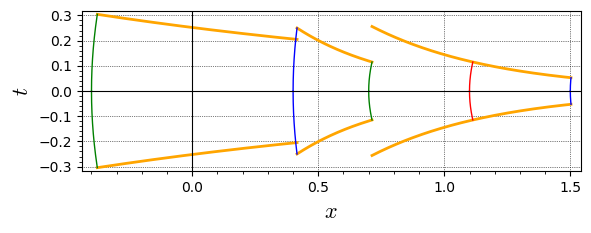

In [56]:
# Пример использования:
# accelerations
A1 = 0.5
A2 = 2

#half-length of the charges
L = 0.4

# distance between centers of the charges
D = 1.1

# time duration of the tube
T1r = 0.25
T2l = 0.115

# time when velocity of charge is zero
T1_0 = 0
T2_0 = -0

# Режим 'exponential'
p = tubes_plot_exponential_1r_2l(A1, A2, L, D, T1r, T2l, mode='exponential')

p.show(aspect_ratio=1, axes_labels=['$x$', '$t$'], gridlines=True, frame=True, figsize=6)

x_left_min1 -0.399999000000000
x_left_max1 0.00312500000000000
f_left1(x_left_min1) 0.2558118576130485
f_left1(x_left_max1) -2.589454172900137
x_right_min1 0.403125000000000
x_right_max1 0.803125000000000
f_right1(x_right_min1) -0.009802640211919261
f_right1(x_right_max1) -2.608675086303478
Error in find_root for right boundary: f appears to have no zero on the interval
t_exp1 x |--> (t1_0 + t_1)*e^(1/2*(a_1*(t1_0 - t_1)^2 - 2*x)*a_1)
xL_exp1 -0.3966149040080758
xR_exp1 0.403125000000000
0.05205770677802145
-0.6196076933169924


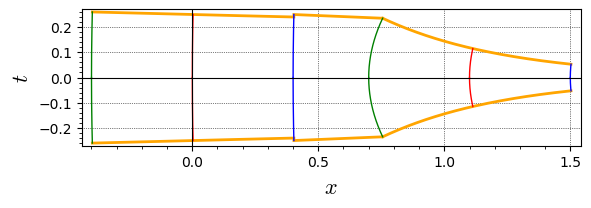

In [57]:
# Пример использования:
# accelerations
A1 = 0.1
A2 = 2

#half-length of the charges
L = 0.4

# distance between centers of the charges
D = 1.1

# time duration of the tube
T1 = 0.25
T2 = 0.115

# time when velocity of charge is zero
T1_0 = 0
T2_0 = -0

# Режим 'exponential'
p = tubes_plot_exponential(A1, A2, L, D, T1, T2, mode='exponential')

p.show(aspect_ratio=1, axes_labels=['$x$', '$t$'], gridlines=True, frame=True, figsize=6)

In [42]:
# accelerations
A1 = 1.2
A2 = 1

#half-length of the charges
L = 0.4

# distance between centers of the charges
D = 3*L + 0.05

# time duration of the tube
T1 = 0.70
T2 = 0.1

# time when velocity of charge is zero
T1_0 = 0.4
T2_0 = -0.1
T1_0 = 0
T2_0 = -0

type(T1)

<class 'sage.rings.real_mpfr.RealLiteral'>

In [10]:
from scipy.optimize import fsolve

def equations(vars):
    T1, T2 = vars
    # Вычисляем x_R1, x_L2, t_R1, t_L2
    x_R1 = 0.5 * A1 * T1**2 + L
    x_L2 = D + 0.5 * A2 * T2**2 - L
    t_R1 = T1_0 + T1
    t_L2 = T2_0 + T2

    # Условие: k = A1 и k = A2 — но они разные, поэтому минимизируем разницу
    k = (1/(x_L2 - x_R1)) * log(t_L2 / t_R1)
    error1 = k - A1
    error2 = k - A2
    return [error1, error2]


In [11]:
from math import log

def equations(vars):
    T1, T2 = vars
    # Вычисляем x_R1, x_L2, t_R1, t_L2
    x_R1 = 0.5 * A1 * T1**2 + L
    x_L2 = D + 0.5 * A2 * T2**2 - L
    t_R1 = T1_0 + T1
    t_L2 = T2_0 + T2

    # Условие: k = A1 и k = A2 — но они разные, поэтому минимизируем разницу
    if x_L2 <= x_R1:
        return [1e6, 1e6]  # большая ошибка, чтобы fsolve не выбрал это решение
    if t_R1 <= 0 or t_L2 <= 0:
        return [1e6, 1e6]

    try:
        k = (1/(x_L2 - x_R1)) * log(t_L2 / t_R1)
    except ValueError:
        return [1e6, 1e6]

    # Производная экспоненты в точке x_R1: t'(x_R1) = -k t_R1
    # Производная границы в точке x_R1: t_1'(x_R1) = 1/(A1 t_R1)
    # Условие перпендикулярности: t'(x_R1) = -A1 t_R1
    error1 = -k * t_R1 + A1 * t_R1

    # Аналогично для второй точки
    error2 = -k * t_L2 + A2 * t_L2

    return [error1, error2]

In [12]:
from scipy.optimize import minimize

def objective(vars):
    T1, T2 = vars
    if T1 <= 0 or T2 <= 0:
        return 1e6
    errors = equations([T1, T2])
    return errors[0]**2 + errors[1]**2

result = minimize(objective, [0.5, 0.1], bounds=[(1e-6, None), (1e-6, None)])
T1_opt, T2_opt = result.x
T1_opt, T2_opt

(1e-06, 1e-06)

In [13]:
T1_opt, T2_opt = fsolve(equations, [0.5, 0.1])
T1_opt, T2_opt

/usr3/articles/sagemath_docker_build/sage/local/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(1.60438397e-316, 2.61820786e-316)

In [14]:
# time duration of the tube
T1 = RR(T1_opt)
T2 = RR(T2_opt)
type(T1)

<class 'sage.rings.real_mpfr.RealNumber'>

m1 = -a_1*t_1


-a_1*t_1

m2 = -a_2*t_2


-a_2*t_2

perp_1 = 1/2*a_1^2*t_1^3 - a_1*t_1*x + t_1


1/2*a_1^2*t_1^3 - a_1*t_1*x + t_1

perp_2 = 1/2*(a_2*t_2^2 + 2*d)*a_2*t_2 - a_2*t_2*x + t_2


1/2*(a_2*t_2^2 + 2*d)*a_2*t_2 - a_2*t_2*x + t_2

x_1_r = 1/2*(a_1^4*t_1^4 + 2*a_1^2*t_1^2 - 2*sqrt(a_1^4*t_1^4 + 2*sqrt(2)*a_1^4*t1_0*t_1^2*sqrt(-(l - x)/a_1) + (a_1^4*t1_0^2 - 2*a_1^3*l + 2*a_1^2)*t_1^2 + 1) + 2)/(a_1^3*t_1^2)


1/2*(a_1^4*t_1^4 + 2*a_1^2*t_1^2 - 2*sqrt(a_1^4*t_1^4 + 2*sqrt(2)*a_1^4*t1_0*t_1^2*sqrt(-(l - x)/a_1) + (a_1^4*t1_0^2 - 2*a_1^3*l + 2*a_1^2)*t_1^2 + 1) + 2)/(a_1^3*t_1^2)

x_2_l = 1/2*(a_2^4*t_2^4 + 2*(a_2^3*d + a_2^2)*t_2^2 - 2*sqrt(a_2^4*t_2^4 + 2*sqrt(2)*a_2^4*t2_0*t_2^2*sqrt(-(d - l - x)/a_2) + (a_2^4*t2_0^2 + 2*a_2^3*l + 2*a_2^2)*t_2^2 + 1) + 2)/(a_2^3*t_2^2)


1/2*(a_2^4*t_2^4 + 2*(a_2^3*d + a_2^2)*t_2^2 - 2*sqrt(a_2^4*t_2^4 + 2*sqrt(2)*a_2^4*t2_0*t_2^2*sqrt(-(d - l - x)/a_2) + (a_2^4*t2_0^2 + 2*a_2^3*l + 2*a_2^2)*t_2^2 + 1) + 2)/(a_2^3*t_2^2)

t_1_r = sqrt(2)*sqrt(1/2)*sqrt(-(2*l - (a_1^4*t_1^4 + 2*a_1^2*t_1^2 - 2*sqrt(a_1^4*t_1^4 + 2*sqrt(2)*a_1^4*t1_0*t_1^2*sqrt(-(l - x)/a_1) + (a_1^4*t1_0^2 - 2*a_1^3*l + 2*a_1^2)*t_1^2 + 1) + 2)/(a_1^3*t_1^2))/a_1) + t1_0


sqrt(2)*sqrt(1/2)*sqrt(-(2*l - (a_1^4*t_1^4 + 2*a_1^2*t_1^2 - 2*sqrt(a_1^4*t_1^4 + 2*sqrt(2)*a_1^4*t1_0*t_1^2*sqrt(-(l - x)/a_1) + (a_1^4*t1_0^2 - 2*a_1^3*l + 2*a_1^2)*t_1^2 + 1) + 2)/(a_1^3*t_1^2))/a_1) + t1_0

t_2_l = sqrt(2)*sqrt(1/2)*sqrt(-(2*d - 2*l - (a_2^4*t_2^4 + 2*(a_2^3*d + a_2^2)*t_2^2 - 2*sqrt(a_2^4*t_2^4 + 2*sqrt(2)*a_2^4*t2_0*t_2^2*sqrt(-(d - l - x)/a_2) + (a_2^4*t2_0^2 + 2*a_2^3*l + 2*a_2^2)*t_2^2 + 1) + 2)/(a_2^3*t_2^2))/a_2) + t2_0


sqrt(2)*sqrt(1/2)*sqrt(-(2*d - 2*l - (a_2^4*t_2^4 + 2*(a_2^3*d + a_2^2)*t_2^2 - 2*sqrt(a_2^4*t_2^4 + 2*sqrt(2)*a_2^4*t2_0*t_2^2*sqrt(-(d - l - x)/a_2) + (a_2^4*t2_0^2 + 2*a_2^3*l + 2*a_2^2)*t_2^2 + 1) + 2)/(a_2^3*t_2^2))/a_2) + t2_0

x_1_r = 0.402880146914697


0.402880146914697

x_2_l = -0.396620165638239


0.740308877281291

perp_1 = -0.0250000000000000*x + 0.250078125000000


-0.0250000000000000*x + 0.250078125000000

perp_2 = -0.230000000000000*x + 0.371041750000000


-0.230000000000000*x + 0.371041750000000

t_1_r = 0.240006121367639*sqrt(2)*sqrt(1/2)


0.240006121367639*sqrt(2)*sqrt(1/2)

t_2_l = 0.200770708225305*sqrt(2)*sqrt(1/2)


0.200770708225305*sqrt(2)*sqrt(1/2)

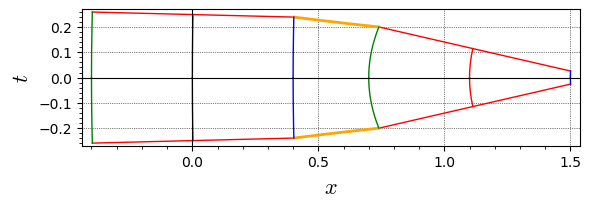

In [15]:
# Пример использования:
# accelerations
A1 = 0.1
A2 = 2

#half-length of the charges
L = 0.4

# distance between centers of the charges
D = 1.1

# time duration of the tube
T1 = 0.25
T2 = 0.115

# time when velocity of charge is zero
T1_0 = 0
T2_0 = -0

# Режим 'simple' — как было
p = tubes_plot_simple(A1, A2, L, D, T1, T2, mode='simple')

p.show(aspect_ratio=1, axes_labels=['$x$', '$t$'], gridlines=True, frame=True, figsize=6)

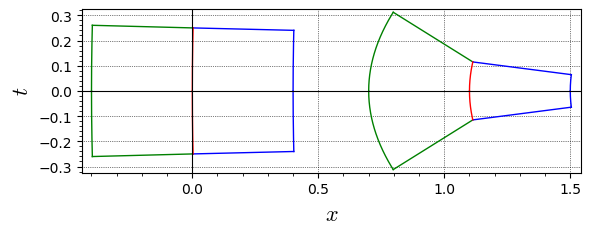

In [16]:
# Пример использования:

# Режим 'perp' — как во втором рисунке
p = tubes_plot(A1, A2, L, D, T1, T2, mode='perp')

p.show(aspect_ratio=1, axes_labels=['$x$', '$t$'], gridlines=True, frame=True, figsize=6)

f_left1(x_left_min1) 0.25581185761302366
f_left1(x_left_max1) -4.674575130990487
f_right1(x_right_min1) nan
f_right1(x_right_max1) -2.608675086303478

NaN result encountered.

NaN result encountered.
Error in find_root for right boundary: f appears to have no zero on the interval
0.05205770677813247
-0.6196076933169924


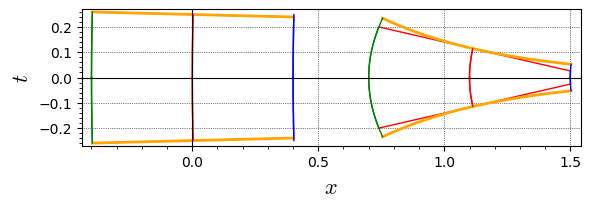

In [17]:
# Пример использования:
p = tubes_plot(A1, A2, L, D, T1, T2, mode='perp')
p = tubes_plot(A1, A2, L, D, T1, T2, mode='simple')
p += tubes_plot(A1, A2, L, D, T1, T2, T1_start = T1_0, T2_start = T2_0, mode='exponential')
p.show(aspect_ratio=1, axes_labels=['$x$', '$t$'], gridlines=True, frame=True, figsize=6)

f_left1(x_left_min1) 0.25581185761302366
f_left1(x_left_max1) -2.589454172900137
f_right1(x_right_min1) nan
f_right1(x_right_max1) -2.608675086303478

NaN result encountered.

NaN result encountered.
Error in find_root for right boundary: f appears to have no zero on the interval
0.05205770677813247
-0.6196076933169924


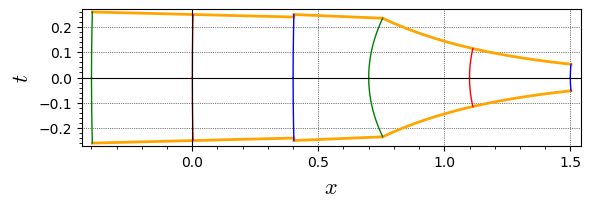

In [77]:
# Пример использования:

p = tubes_plot(A1, A2, L, D, T1, T2, T1_start = T1_0, T2_start = T2_0, mode='exponential_between')

p.show(aspect_ratio=1, axes_labels=['$x$', '$t$'], gridlines=True, frame=True, figsize=6)

f_left1(x_left_min1) 0.25581185761302366
f_left1(x_left_max1) -2.589454172900137
f_right1(x_right_min1) nan
f_right1(x_right_max1) -2.608675086303478

NaN result encountered.

NaN result encountered.
Error in find_root for right boundary: f appears to have no zero on the interval
0.05205770677813247
-0.6196076933169924


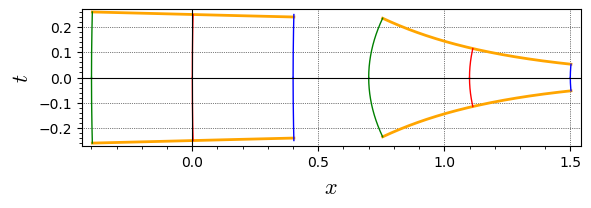

In [78]:
# Пример использования:

# Режим 'simple' — как было
#p = tubes_plot(A1, A2, L, D, T1, T2, mode='simple')

# Режим 'perp' — как во втором рисунке
#p = tubes_plot(A1, A2, L, D, T1, T2, mode='perp')

p = tubes_plot(A1, A2, L, D, T1, T2, T1_start = T1_0, T2_start = T2_0, mode='exponential')

p.show(aspect_ratio=1, axes_labels=['$x$', '$t$'], gridlines=True, frame=True, figsize=6)

x_left_min1 -0.399999000000000
x_left_max1 0.00312500000000000
f_left1(x_left_min1) 0.25581185761302366
f_left1(x_left_max1) -2.589454172900137
x_right_min1 0.403125000000000
x_right_max1 0.803125000000000
f_right1(x_right_min1) -0.009802640211919261
f_right1(x_right_max1) -2.608675086303478
Error in find_root for right boundary: f appears to have no zero on the interval
t_exp1 x |--> 0.250000000000000*e^(1/2*(a_1*t_1^2 - 2*x)*a_1)
xL_exp1 -0.39661490400807586
xR_exp1 0.403125000000000
0.05205770677813246
-0.6196076933169924


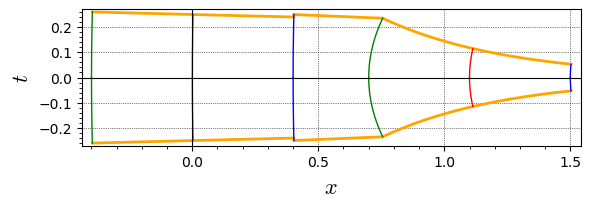

In [79]:

# Режим 'exponential'
p = tubes_plot_exponential(A1, A2, L, D, T1, T2, mode='exponential')

p.show(aspect_ratio=1, axes_labels=['$x$', '$t$'], gridlines=True, frame=True, figsize=6)

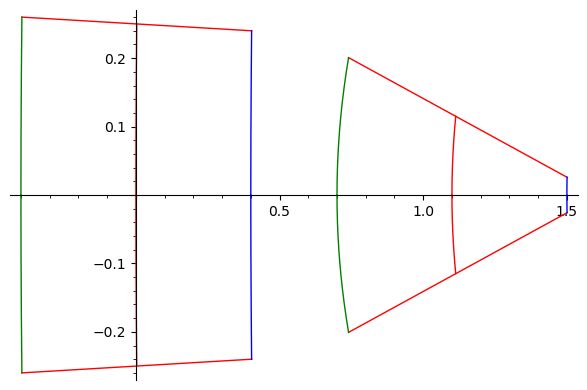

In [20]:
tubes_plot(A1, A2, L, D, T1, T2)

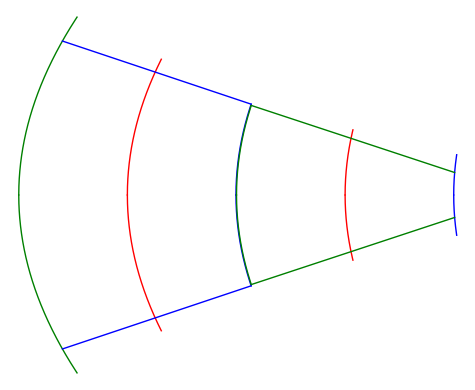

In [591]:
@interact
def _(A1=slider(srange(0,10,.1),default = 2),
      A2=slider(srange(0,10,.1),default = 2),
      T1=slider(srange(.005,1,.005),default = 0.25),
      T2=slider(srange(.005,1,.005),default = 0.16),
      D=slider(srange(.01,10,.01),default = 2*L + 0.02)):
    tubes_plot_simple(A1, A2, L, D, T1, T2, mode='simple', logging=False).show(aspect_ratio=1)

Interactive function <function _ at 0x7f62d3a7d240> with 5 widgets
  A1: SelectionSlider(description='A1', ind…

In [432]:
@interact
def _(A1=slider(srange(0,10,.1),default = 2),
      A2=slider(srange(0,10,.1),default = 2),
      T1=slider(srange(.005,1,.005),default = 0.25),
      T2=slider(srange(.005,1,.005),default = 0.16),
      D=slider(srange(.01,10,.01),default = 2*L + 0.02)):
    tubes_plot(A1, A2, L, D=D, T1=T1, T2=T2, mode='exponential_between').show(aspect_ratio=1)

Interactive function <function _ at 0x7f62d480b400> with 5 widgets
  A1: SelectionSlider(description='A1', ind…

nan
-0.6734363117835546
0.06950145120663394
-0.6197155223008016


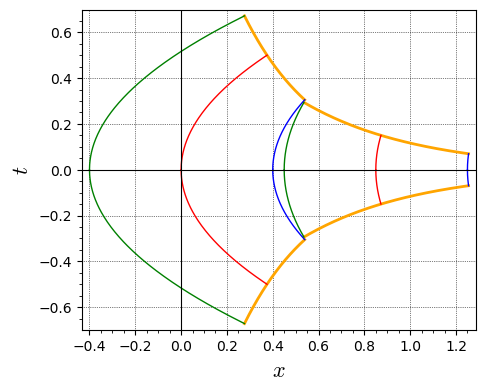

In [238]:
# Пример использования:

# Режим 'simple' — как было
p = tubes_plot(A1, A2, L, D, T1, T2, mode='simple')

# Режим 'perp' — как во втором рисунке
#p = tubes_plot(A1, A2, L, D, T1, T2, mode='perp')

p = tubes_plot(A1, A2, L, D, T1, T2, T1_start = T1_0, T2_start = T2_0, mode='exponential')


p.show(aspect_ratio=1, axes_labels=['$x$', '$t$'], gridlines=True, frame=True, figsize=6)

нужно один из time duration of the tube зафиксировать, а второй варьировать. 

Давай вспомним статью Ферми, в этой статье фиксировалось dt_0. Пусть даже не численно, но аналитически. Это значение фиксировалось dt_0 исходя из того где мы выбирали точку О. И я хочу теперь такой же алгоритм. Мы выбираем точку О где хотим. А именно мы ее можем выбрать в любой точке толщины первого заряда или в любой точке толщины второго заряда. Исходя из этого и из заданного значения dt_0 мы должны теперь найти time duration of the tube
T1 и T2 в области центральной мировой линии

И далее нам нужно искать аналог уравнения 
$$ - dt_0\left\{
\delta x \int \left (1 + \frac{\vec {Г} \cdot \overrightarrow{\left(P - O\right)}}{c^2}\right)\, E_x de
+
\delta y \int \left (1 + \frac{\vec {Г} \cdot \overrightarrow{\left(P - O\right)}}{c^2}\right)\, E_y de
+ \\ +
\delta z \int \left (1 + \frac{\vec {Г} \cdot \overrightarrow{\left(P - O\right)}}{c^2}\right)\, E_z de
\right\}.$$

Из работы Ферми, но теперь уже для двух несинхронно ускоряющихся зарядов в следующем виде

$$
\delta S = -\delta t_0 \left\{
\delta x_1 \int_{V_1} \frac{dt}{dt_0}(\vec {Г}_1, \vec {Г}_2, \overrightarrow{\left(P - O\right)})\, E_x \rho_1 dV_1
+
\delta x_2 \int_{V_2} \frac{dt}{dt_0}(\vec {Г}_1, \vec {Г}_2, \overrightarrow{\left(P - O\right)})\, E_x \rho_2 dV_2
\right\} + \dots
$$

Здесь поправка Ферми без полусуммы $dt = \frac{dt}{dt_0}(\vec {Г}_1, \vec {Г}_2, \overrightarrow{\left(P - O\right)})\,dt_0$ есть функция зависимости дифференциала dt в интеграле действия для вариации В для несинхронно ускоряющихся зарядов, найденная из принципа минимизации поверхностной энергии гиперповерхности пределов интегрирования в интеграле действия. И заметь эта функция зависит как от выбора точки О так и от расстояния между зарядами так же и от обоих ускорений

Это выражение должно обращаться в нуль для всех значений $\delta х_1, \delta x_2$, и поэтому из него получаются три соотношения, которые сводятся к единственному векторному

$$\int \frac{dt}{dt_0}(\vec {Г}_1, \vec {Г}_2, \overrightarrow{\left(P - O\right)})\, \vec E de = 0.\,\,\,(3)$$

Таким образом уравнение движения каждого их несинхронно ускоряющихся зарядов зависит от ускорения каждого из зарядов. Обрати на это особое внимание.

И задача теперь найти точный или приближённый вид такой поправки Ферми, содержащий оба ускорения

Для начала, мы не переходим в локальную систему какого либо из зарядов, мы работаем в лабораторной системе
Далее,  вот посмотри на рисунок, это я на одном графике нарисовал границу интегрирования в режимах exponental и perp, как видишь, разница есть, но она небольшая. Преимущество экспоеннциального режима, он выглядит красивее и кажется точнее, но мы вынуждены были использовать численный find_root, в режиме же perp все вычисления происходят аналитически. И хотя погрешность этого метода больше, но возможность получения аналитической формулы для обобщённой (для двух зарядов) поправки Ферми меня подкупает.

мне сейчас нужно чтобы ты попытался на основании этого рещима получить аналитическое выражение для обобщённой поправки Ферми

текущий Алгоритм perp копирую сюда, изучи его внимательно


Из кода `tubes_plot`:

- Центральная точка первого заряда: $(x_1, t_1) = \left( \frac{1}{2} A1 T1^2, T1 \right)$
- Перпендикуляр к центру: $t = -A1 T1 (x - x_1) + T1$
- Точка пересечения с левой границей: $(x_{1l}, t_{1l})$, где:
  $$
  t_{1l} = \sqrt{\frac{2(x_{1l} + L)}{A1}}, \quad
  t_{1l} = -A1 T1 (x_{1l} - x_1) + T1
  $$

Решая эту систему, ты получаешь $x_{1l}, t_{1l}$.

Аналогично для других точек.

### Шаг 2: найти производные

Производная границы в точке $(x_{1l}, t_{1l})$:
$$
\frac{dt}{dx} = \frac{1}{A1 t_{1l}}
$$

Производная перпендикуляра:
$$
\frac{dt}{dx} = -A1 T1
$$

Условие перпендикулярности:
$$
(-A1 T1) \cdot \left( \frac{1}{A1 t_{1l}} \right) = -1
$$


Далее последовательность действий

1) с разработки функционала perp_between

2) аналитической оптимизации соотношения time duration of the tube T1, T2 (то что не доделано было ранее)

3) собственно обобщённая поправка Ферми



## 🔷 Шаг 1: Модель и обозначения

Рассмотрим **двумерное сечение** пространства-времени: оси $(t, x)$.  
Два заряда движутся вдоль оси $x$, с ускорениями $a_1$, $a_2$, начальные координаты:  
- Заряд 1: $x = 0$,
- Заряд 2: $x = d$.

Их мировые линии (в нерелятивистском приближении, $v \ll c$):

$$
t_1(\tau) = \tau, \quad x_1(\tau) = \frac{1}{2} a_1 \tau^2
$$
$$
t_2(\tau) = \tau, \quad x_2(\tau) = d + \frac{1}{2} a_2 \tau^2
$$

Мировые трубки — узкие полосы вокруг этих линий.

---

## 🔷 Шаг 2: Нормальные сечения

В каждый момент $\tau$, **нормальное сечение** — это прямая, **ортогональная 4-скорости**.

При $v \ll c$, 4-скорость: $u^\mu \approx (c, v)$,  
ортогональный вектор: $(v, c)$,  
в $(t,x)$-сечении: наклон $\frac{dt}{dx} = \frac{v}{c^2}$.

Но при $v \ll c$, можно считать, что **нормальное сечение почти горизонтально**, и его уравнение:

$$
t = \tau + \frac{1}{2c^2} a_i (x - x_i(\tau)) \quad \text{(с точностью до } 1/c^2\text{)}
$$

👉 Однако, для простоты, в **нулевом приближении** (малые скорости, малые ускорения) будем считать, что **нормальные сечения горизонтальны**:  
- В трубке 1: $t = t_1$,
- В трубке 2: $t = t_2$.

---

## 🔷 Шаг 3: Построение гладкой границы $t = t(x)$

Пусть область интегрирования ограничена:
- Снизу: кривая $t = t_{\text{нижн}}(x)$,
- Сверху: кривая $t = t_{\text{верх}}(x)$.

Рассмотрим **верхнюю границу** — она соединяет два нормальных сечения.

Пусть:
- В области заряда 1 ($x \in [0 - \ell, 0 + \ell]$): $t = t_0$,
- В области заряда 2 ($x \in [d - \ell, d + \ell]$): $t = t_0 + \delta t$,
- В промежутке $x \in [\ell, d - \ell]$: плавный переход.

Но! Чтобы минимизировать "длину" границы (аналог $\int \sqrt{1 + (dt/dx)^2} dx$), нужно сделать $dt/dx$ как можно меньше.

👉 **Оптимальная кривая** — **гладкая, с нулевыми производными на концах**.

Используем **кубический сплайн**:

$$
t(x) = 
\begin{cases}
t_0 & x \in [0 - \ell, \ell] \\
t_0 + A(x - \ell)^3 + B(x - \ell)^2 + C(x - \ell) & x \in [\ell, d - \ell] \\
t_0 + \Delta t & x \in [d - \ell, d + \ell]
\end{cases}
$$

Где $\Delta t = \frac{1}{2c^2} a_2 d \cdot t_0$ — поправка из-за разного ускорения.

Условия гладкости:
- $t(\ell) = t_0$, $t'( \ell) = 0$,
- $t(d - \ell) = t_0 + \Delta t$, $t'(d - \ell) = 0$.

Решая, получаем:

$$
t(x) = t_0 + \Delta t \cdot \left( \frac{x - \ell}{d - 2\ell} \right)^2 \left( 3 - 2 \frac{x - \ell}{d - 2\ell} \right)
\quad \text{для} \quad x \in [\ell, d - \ell]
$$

✅ Это — **гладкая, $C^1$ кривая**, без изломов, минимальной "кривизны".



## 🔷 Шаг 4: Минимизация кривизны — кубический сплайн

Минимизация $\int (f'')^2 dx$ при заданных $f, f'$ на концах даёт **кубический сплайн**.

Решение:

$$
f(x) = t_0 + \frac{a_1}{c^2} x \left(1 - \frac{x}{d}\right)^2 + \frac{a_2}{c^2} (x - d) \left(\frac{x}{d}\right)^2
$$

✅ Проверка:
- $f(0) = t_0$, $f'(0) = \frac{a_1}{c^2}$,
- $f(d) = t_0$, $f'(d) = \frac{a_2}{c^2}$,
- Гладкая, без изломов.
